## Урок 1: введение в спортивный анализ данных, Exploration Data Analysis

1. Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;
2. Сделать базовый анализ целевой переменной, сделать выводы;
3. Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;
4. Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;
5. Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?
6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.
7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [40]:
from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

### 1. Базовый анализ данных

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [9]:
train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

In [37]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [15]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

Все признаки числовые, кроме одного строкового поля ID_code

In [16]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<100 and feature
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [17]:
discrete_feature

['target']

На трейне у нас одна только дискретная величина - это таргет

In [18]:
numerical_features2 = test.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features2.shape[1]}")

numerical_features2.columns

count of numeric_features 200


Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [19]:
discrete_feature2 = [
    feature for feature in numerical_features2
    if len(test[feature].unique())<100 and feature
]

print(f"Discrete Variables Count: {len(discrete_feature2)}")

Discrete Variables Count: 0


На тесте у нас дискретных величин нет

In [20]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["ID_code"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


In [21]:
len(continuous_feature)

200

In [56]:
def group(iterable, count):
    """ Группировка элементов последовательности по count элементов """ 
    return zip(*[iter(iterable)] * count)

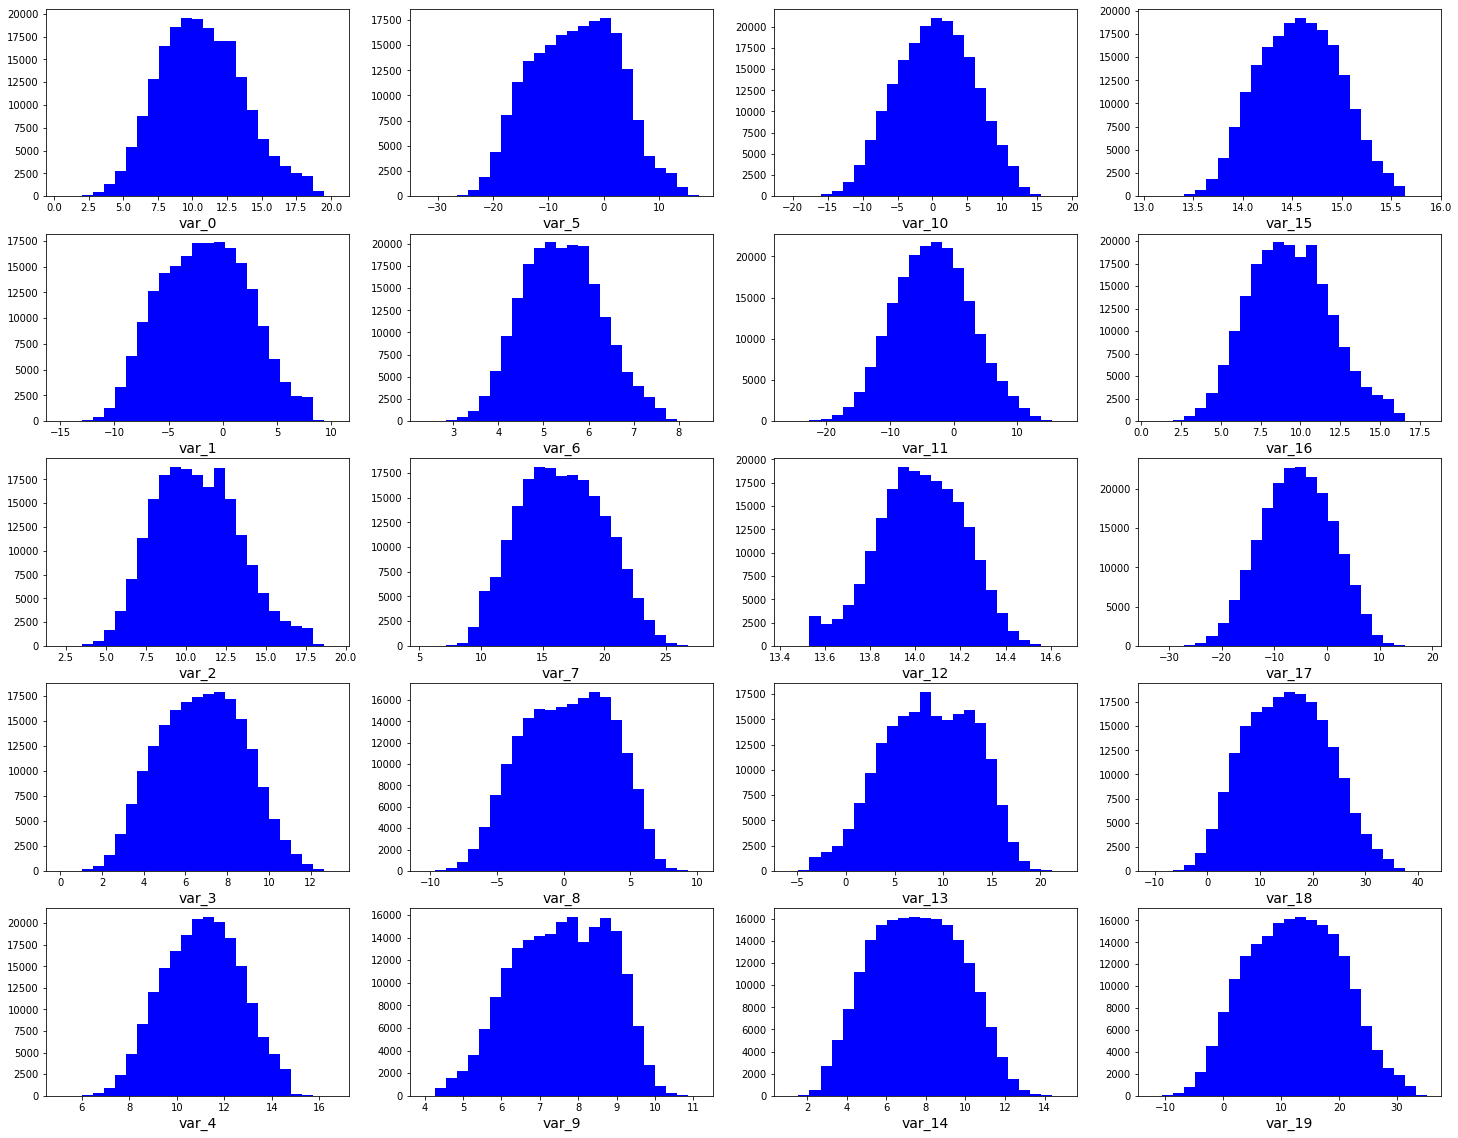

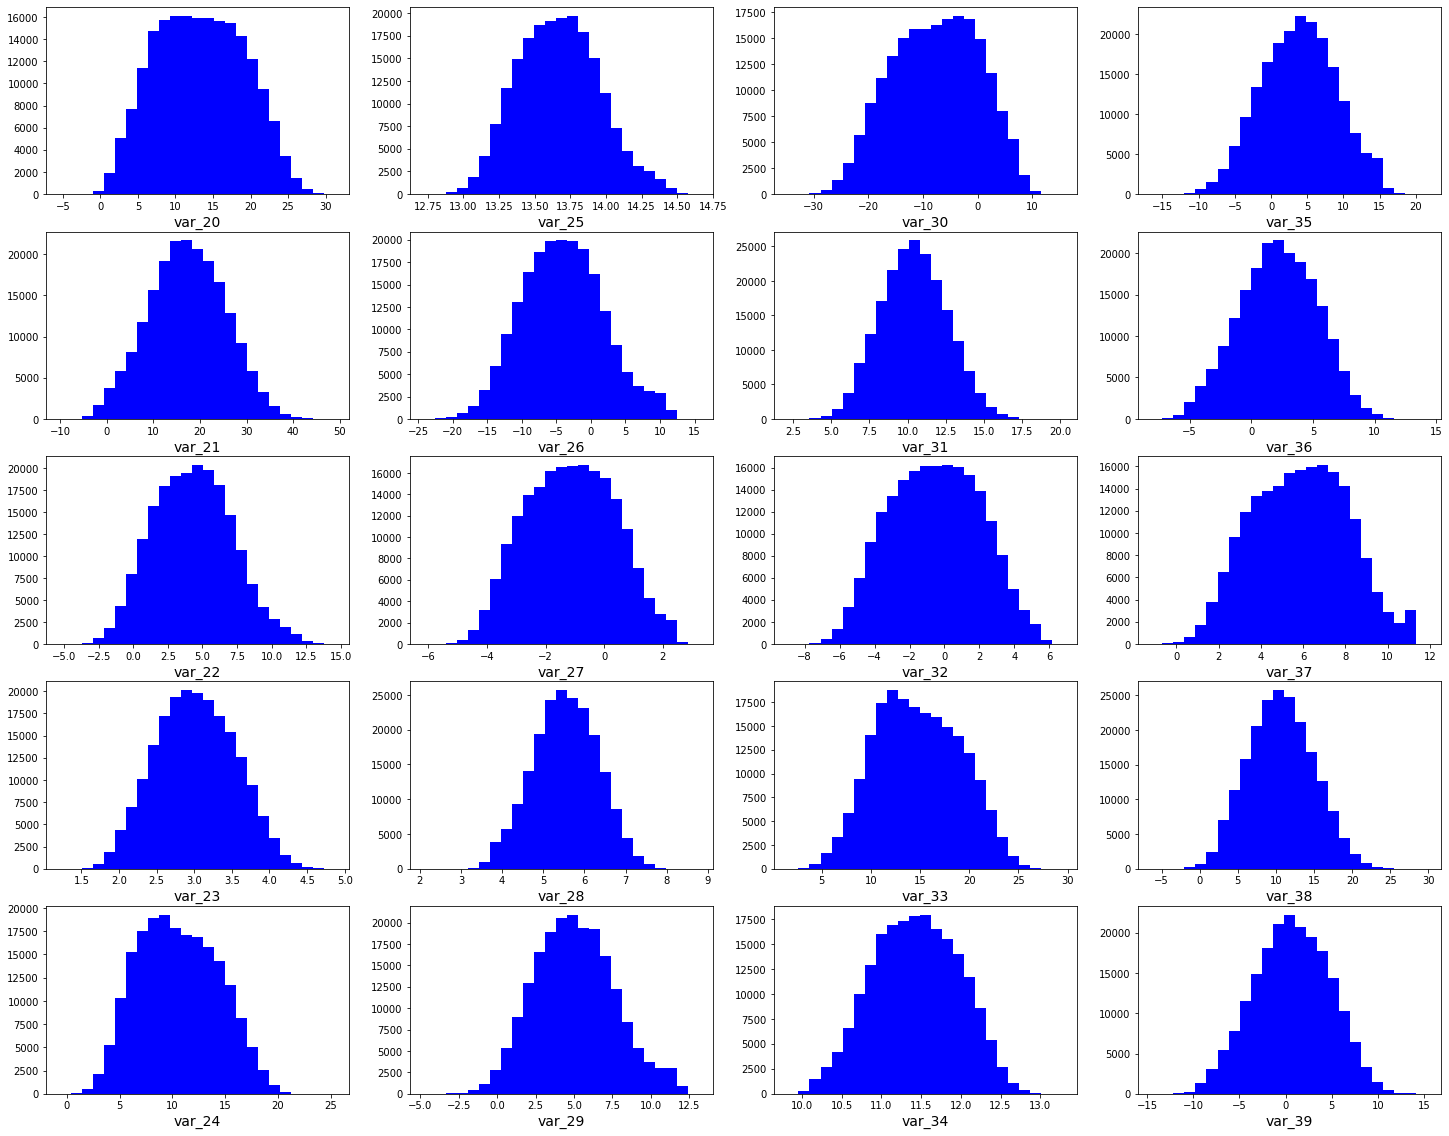

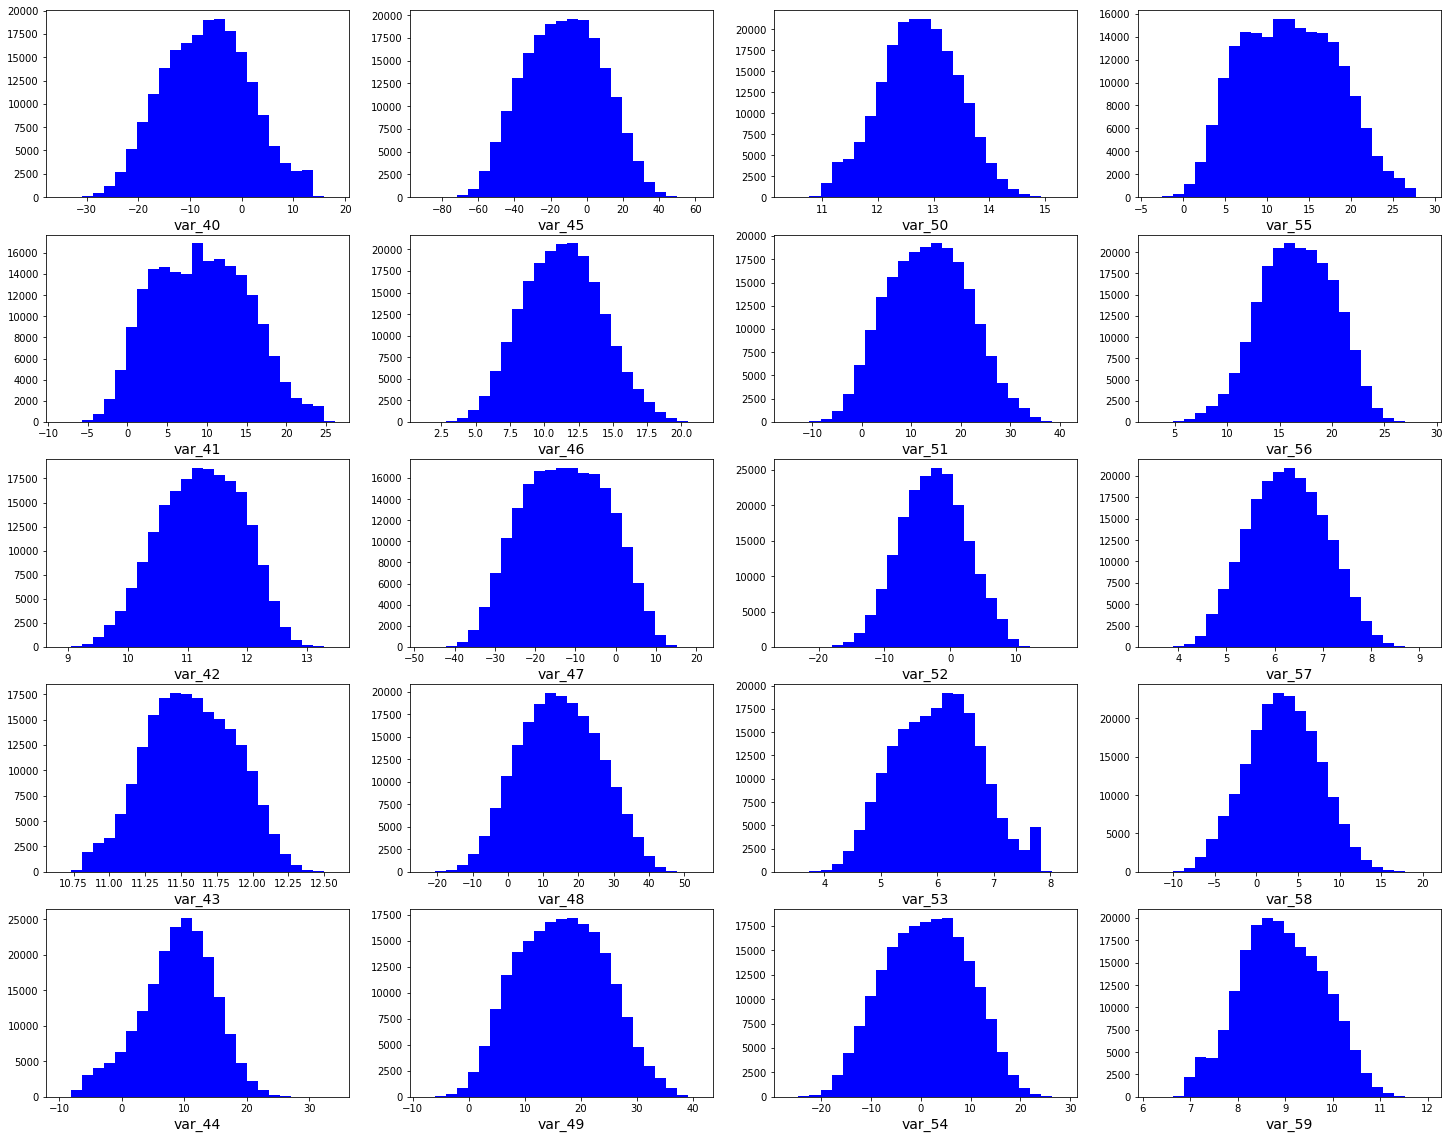

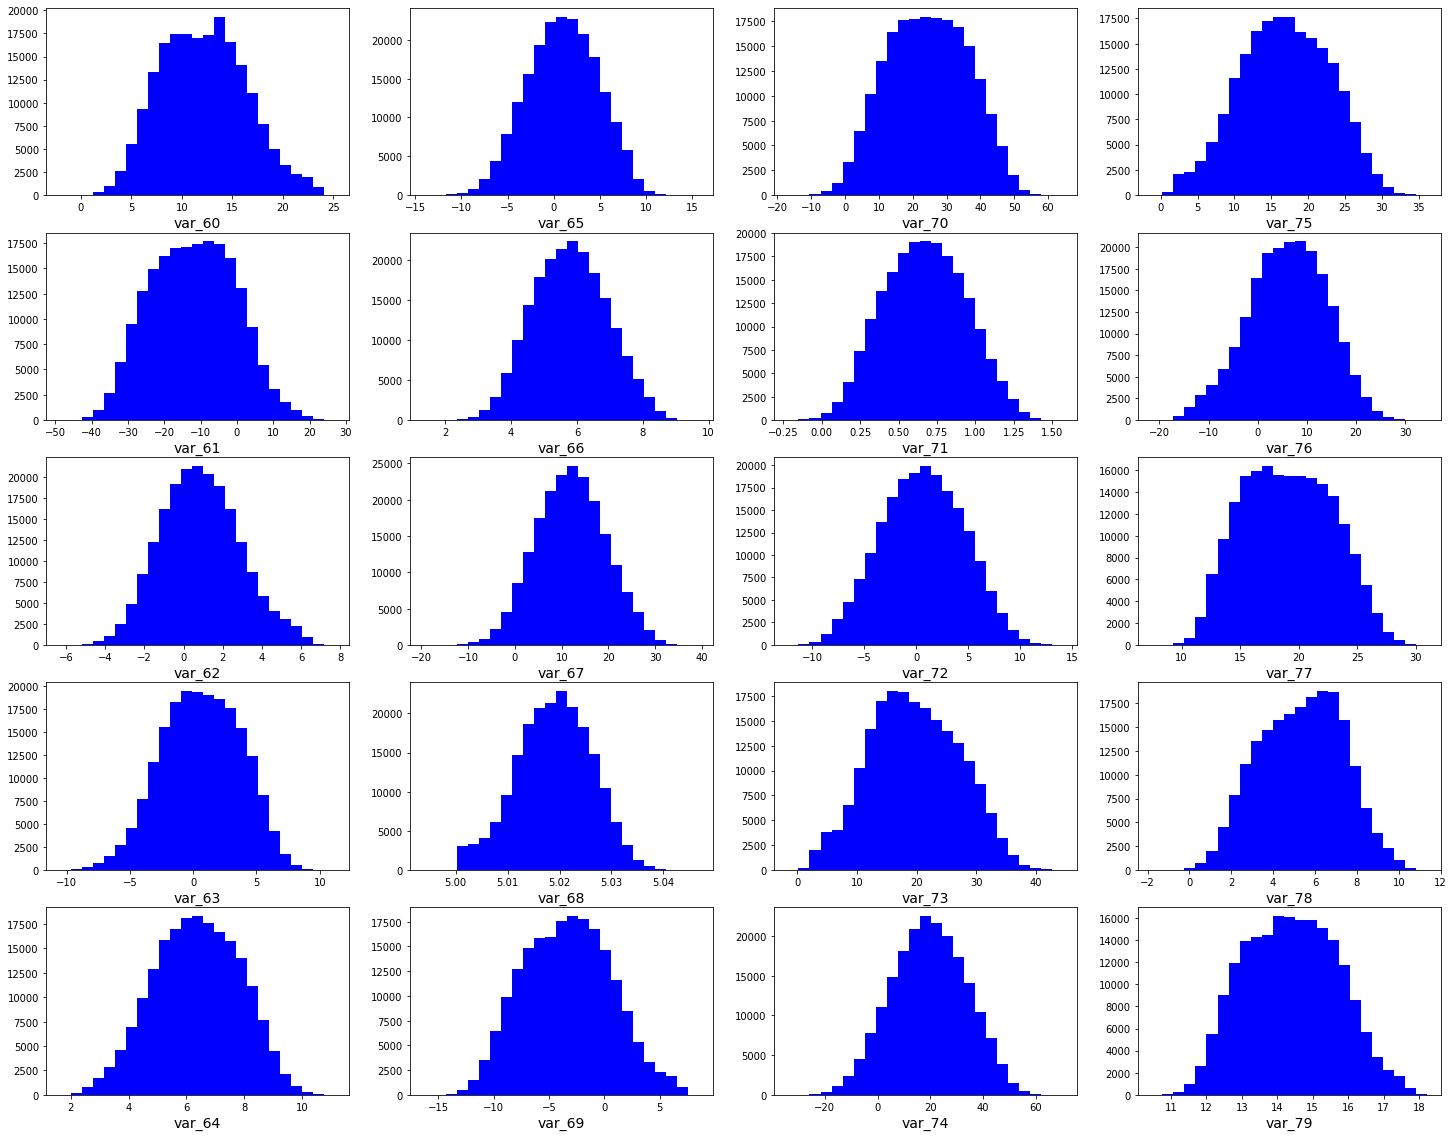

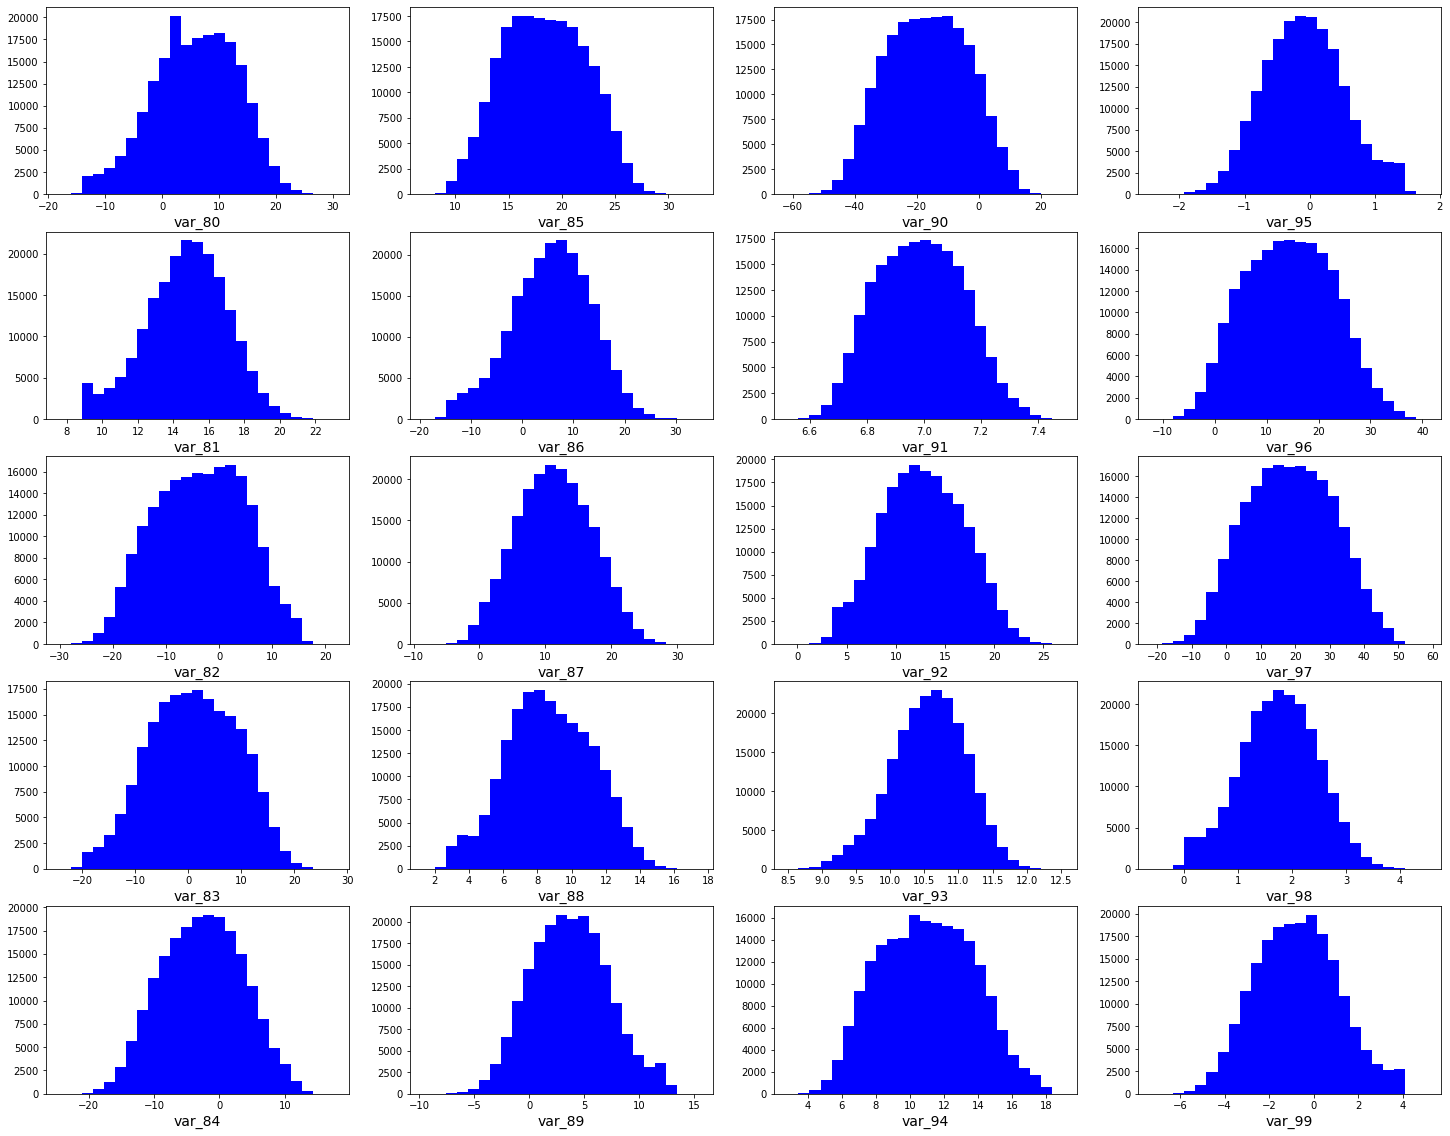

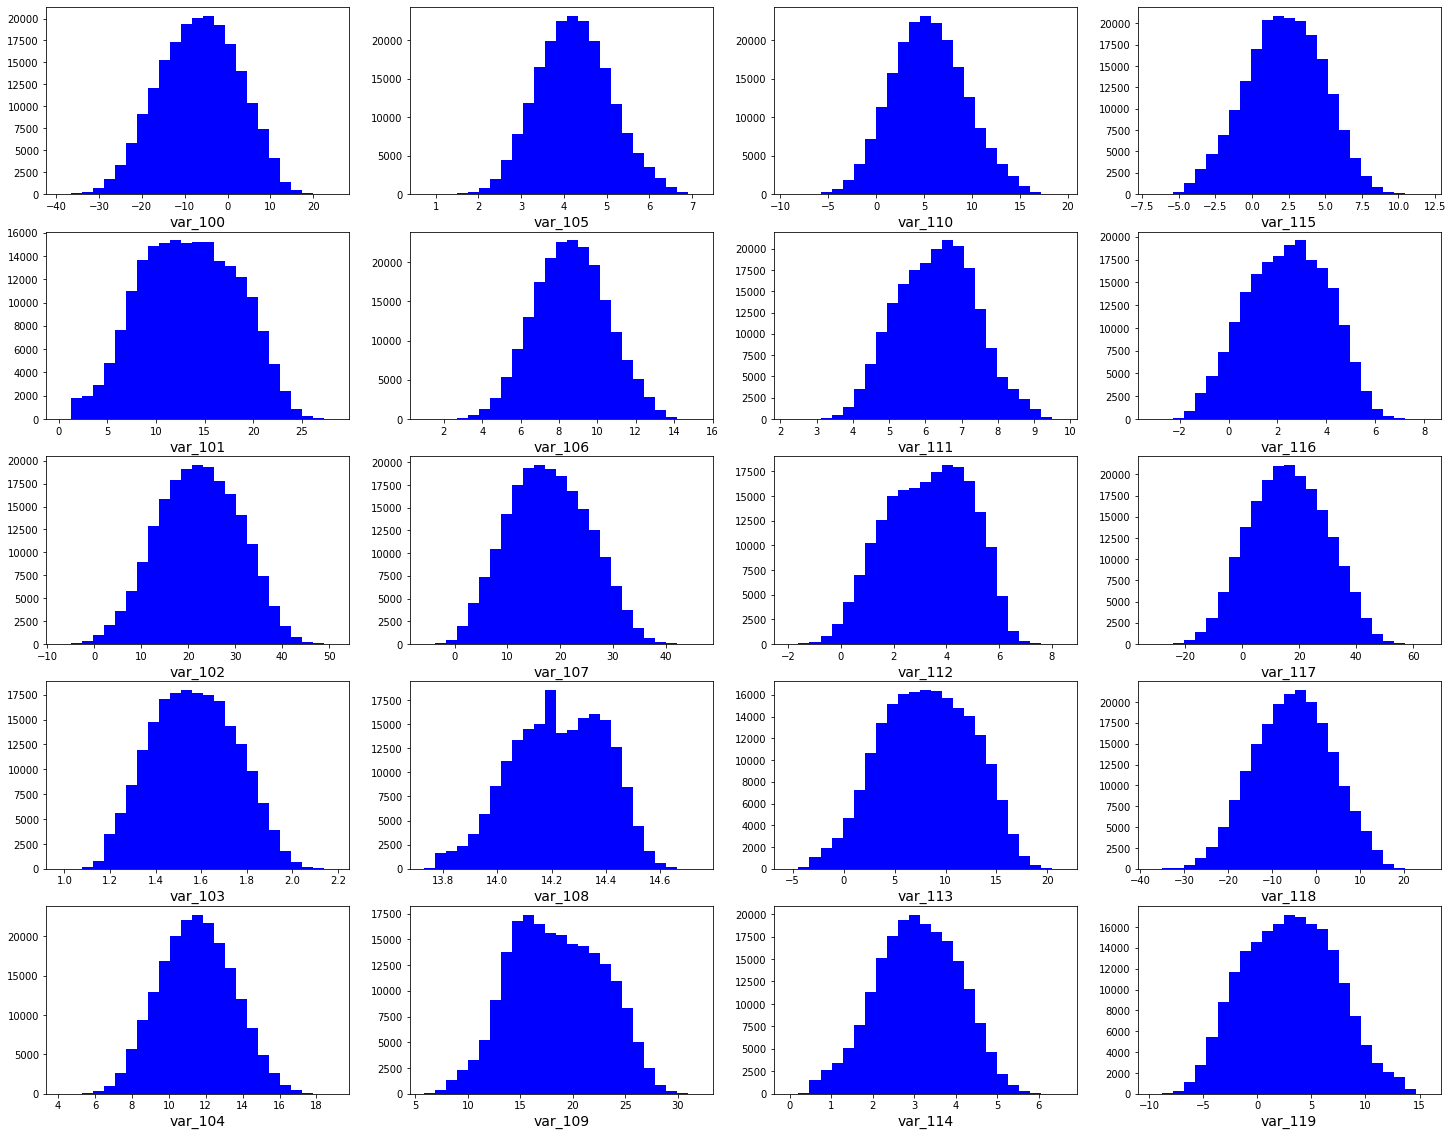

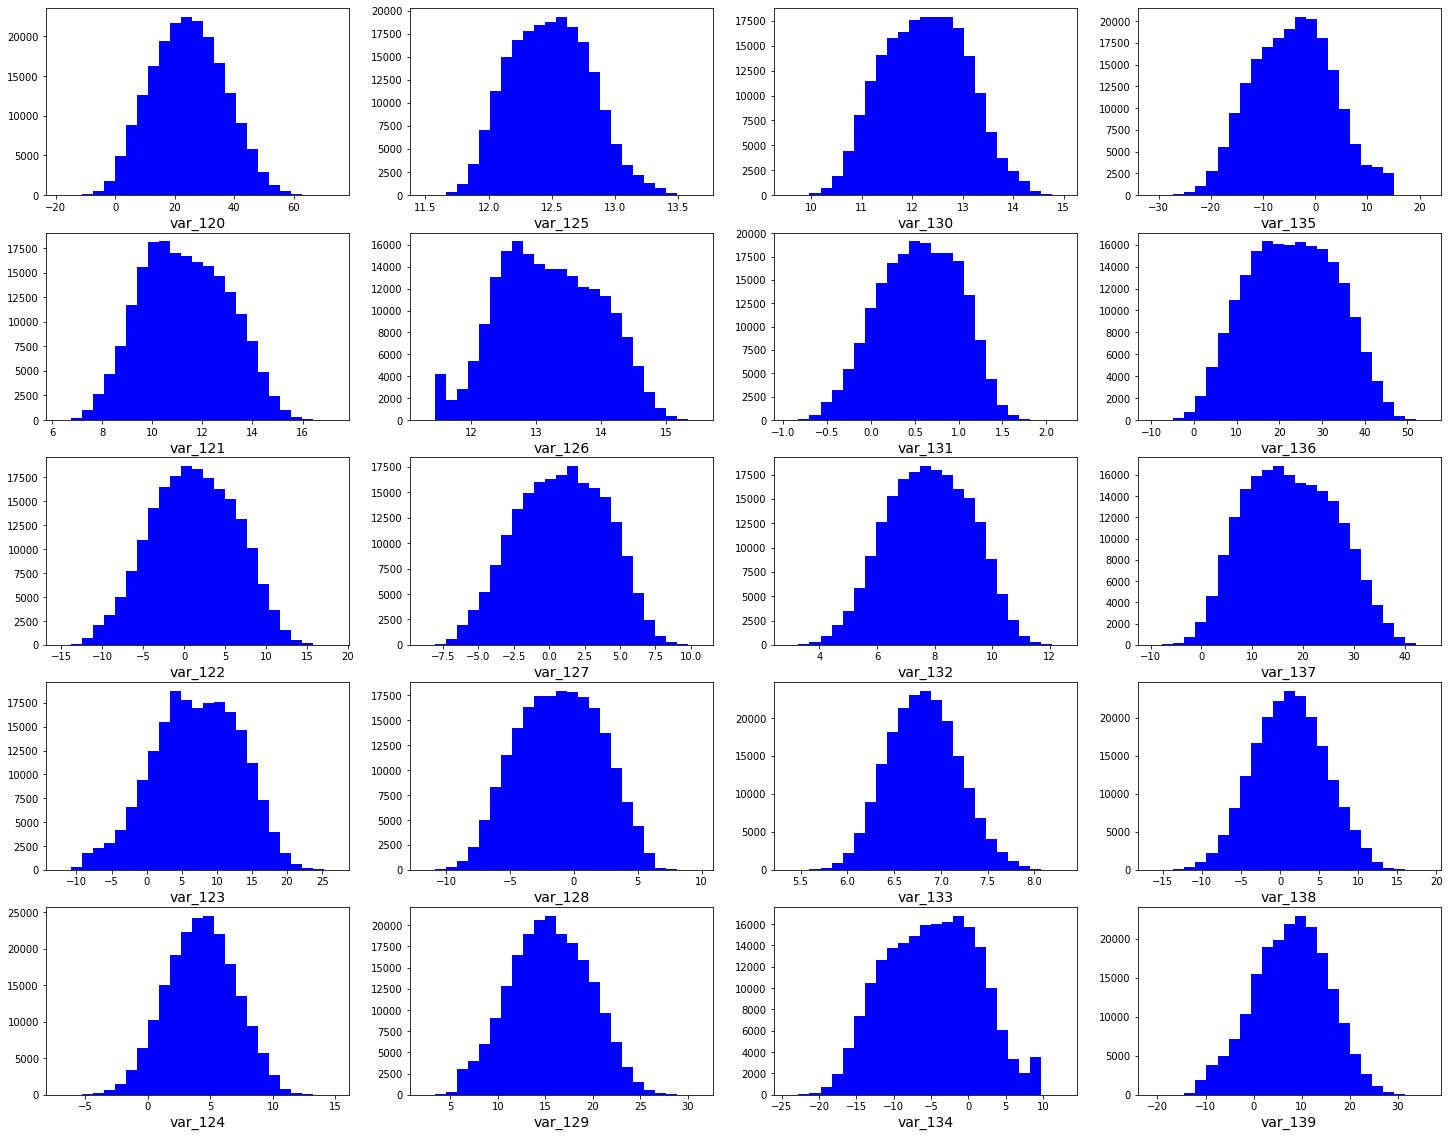

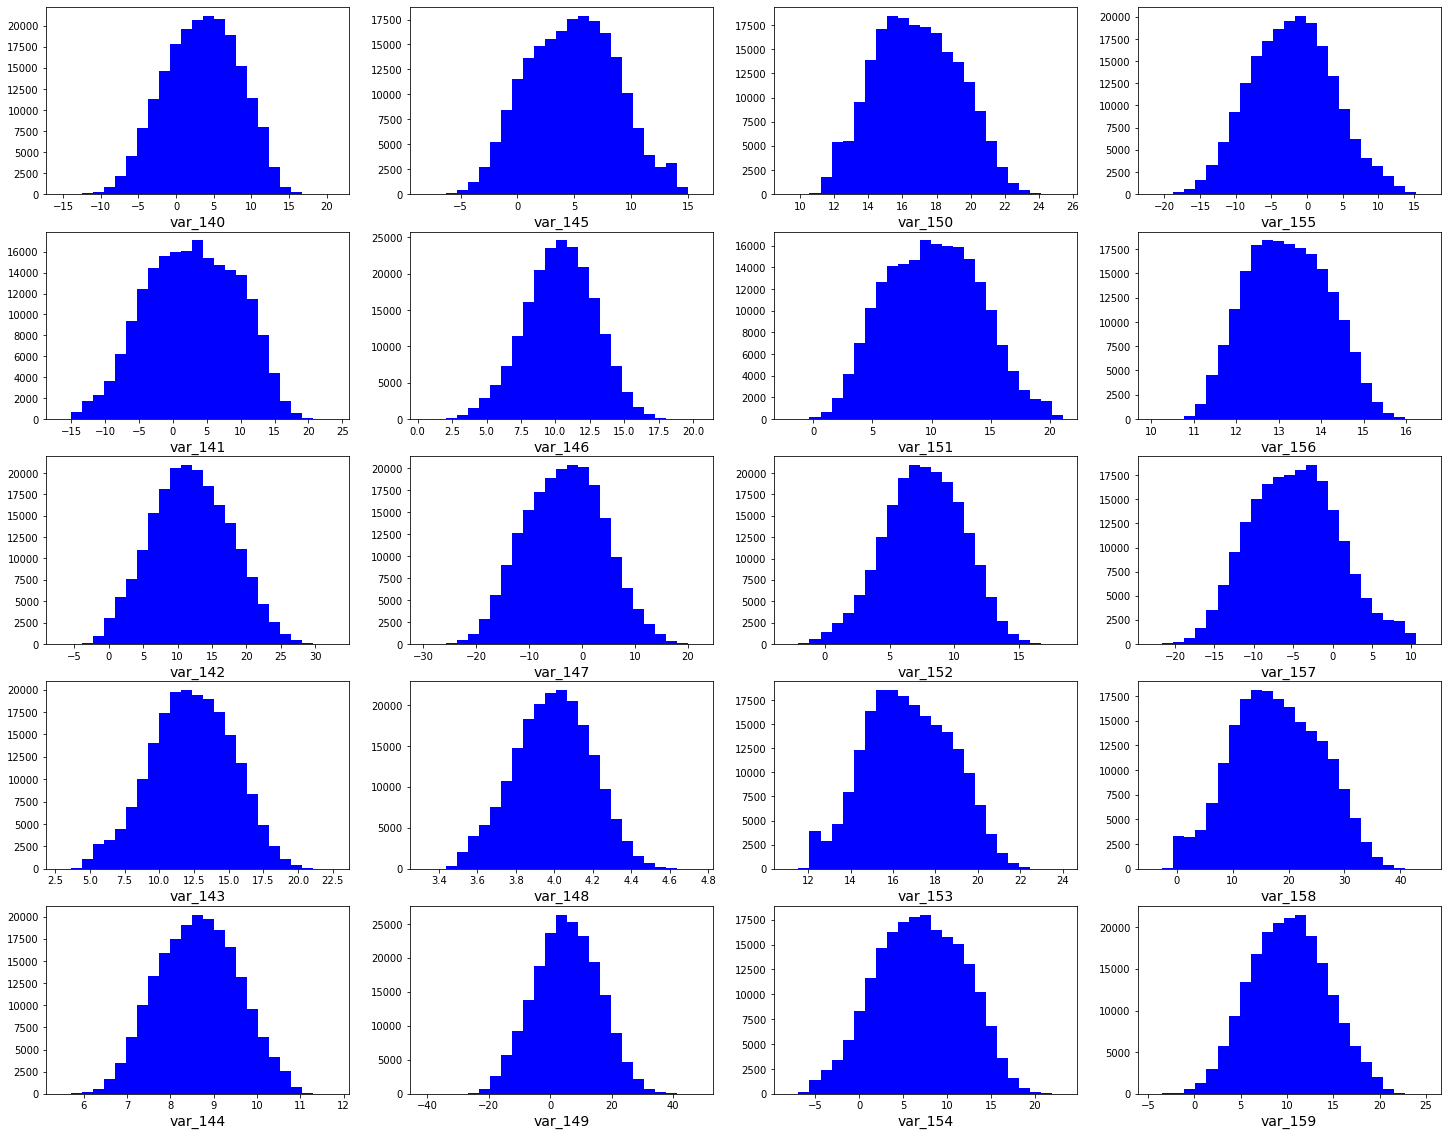

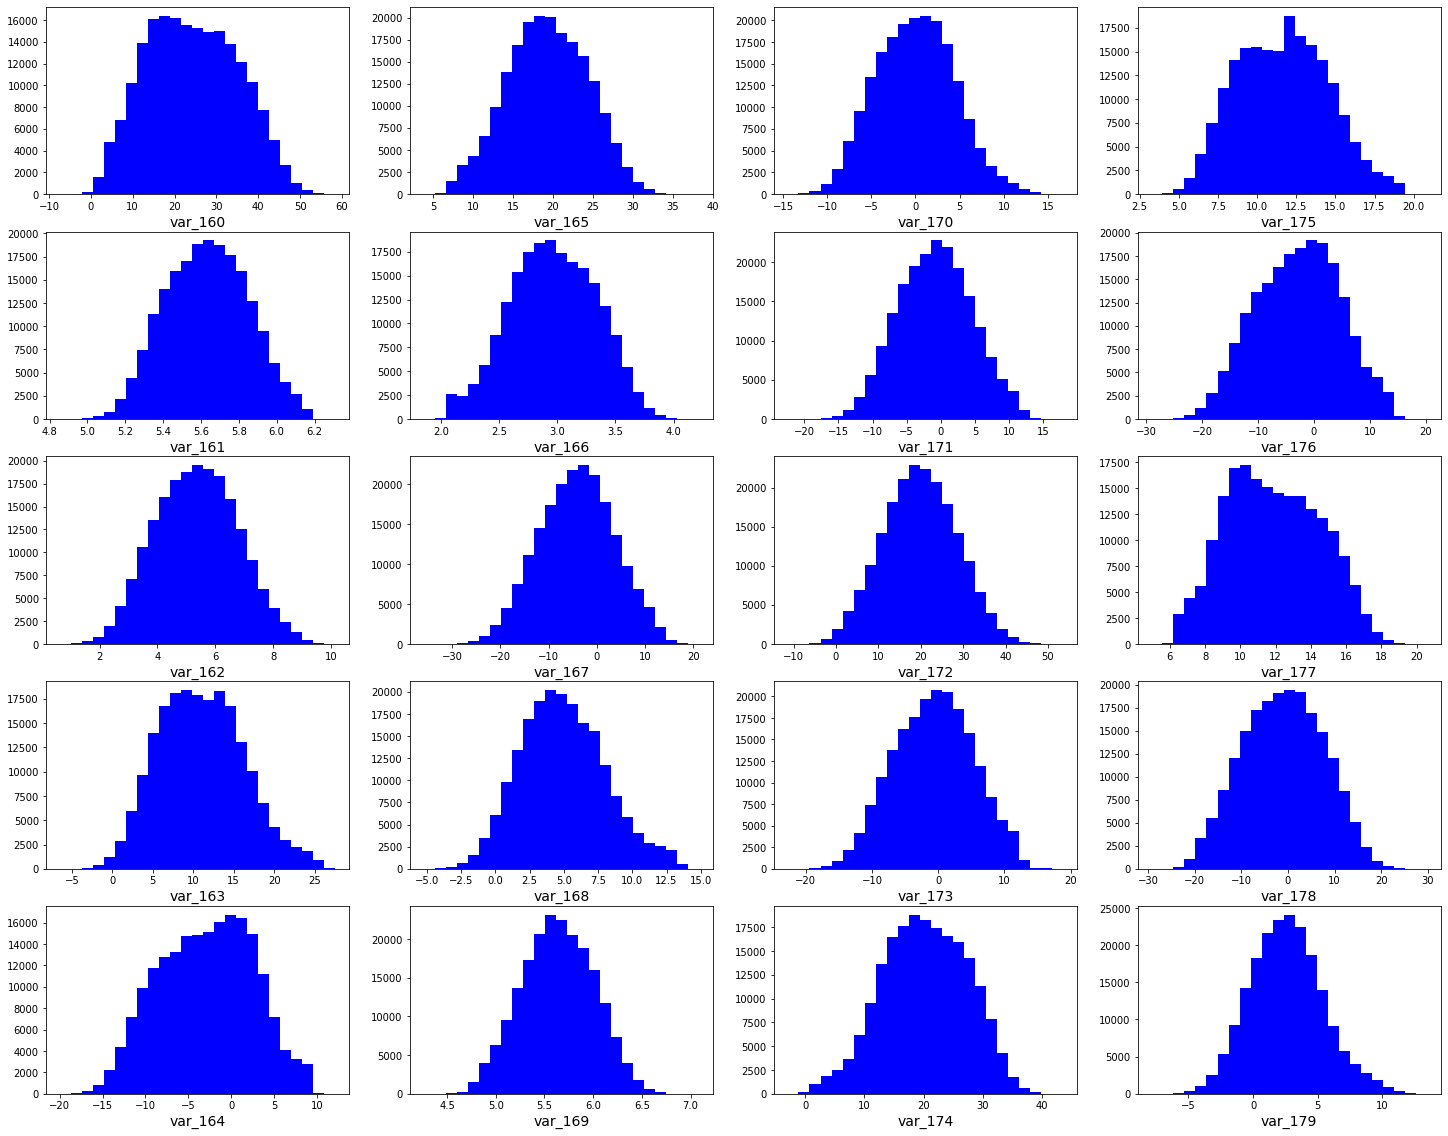

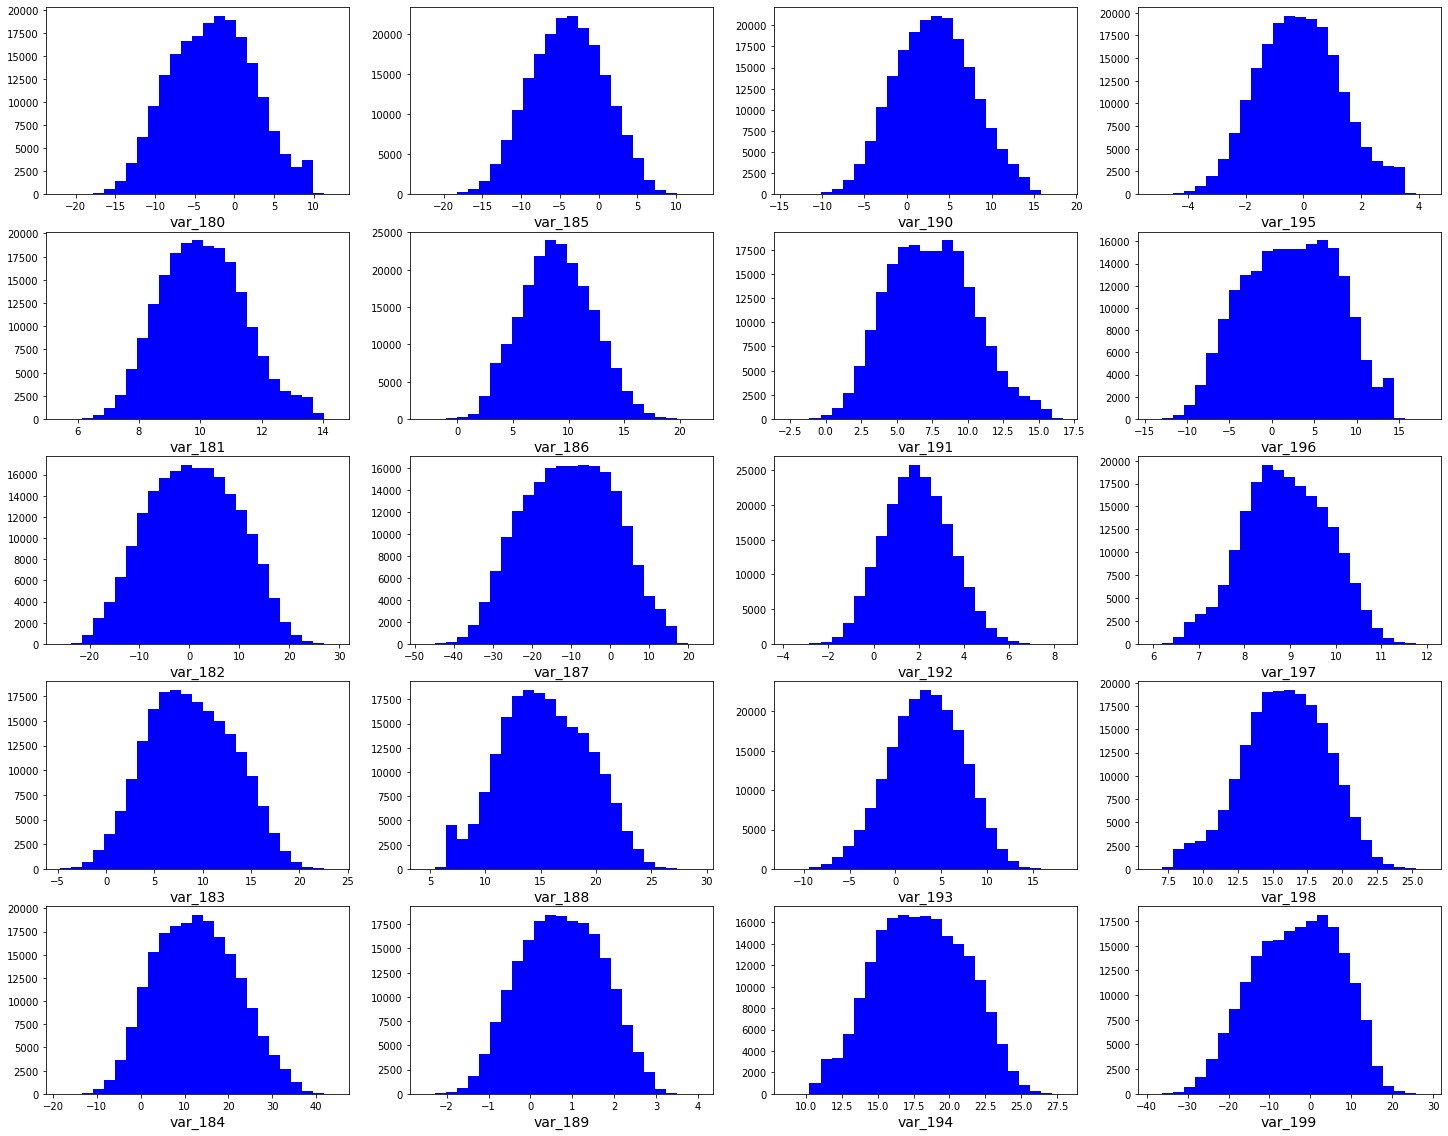

In [62]:
g = group(continuous_feature, 20)

for i in g:
    fig, axes = plt.subplots(5, 4, figsize=(25, 20))
    for num, feature in enumerate(list(i)):
        data = train[feature].copy()
        axes[num%5, num//5].hist(data, bins=25, color="blue")
        axes[num%5, num//5].set_xlabel(feature, fontsize=14)  

Все 200 непрерывных признака распределены почти нормально, просто каждый имеет свое смещение относительно 0.

<AxesSubplot:>

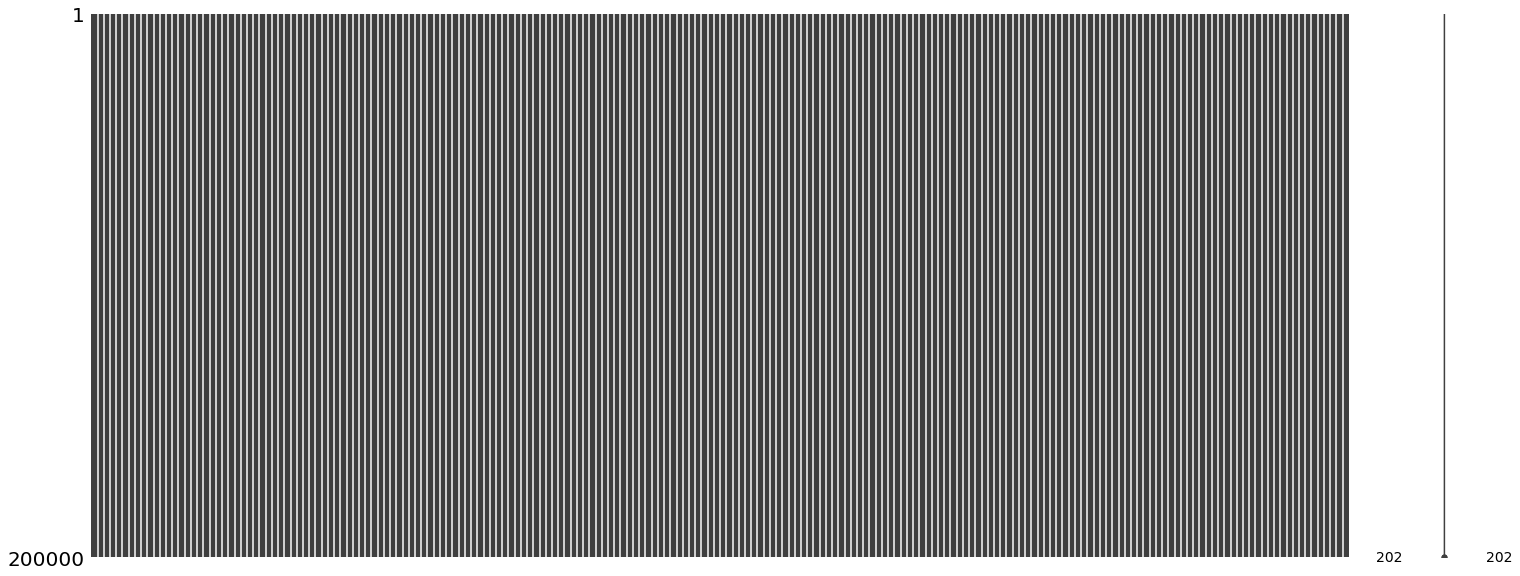

In [65]:
msno.matrix(train)

In [66]:
len(train) - train.count()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

<AxesSubplot:>

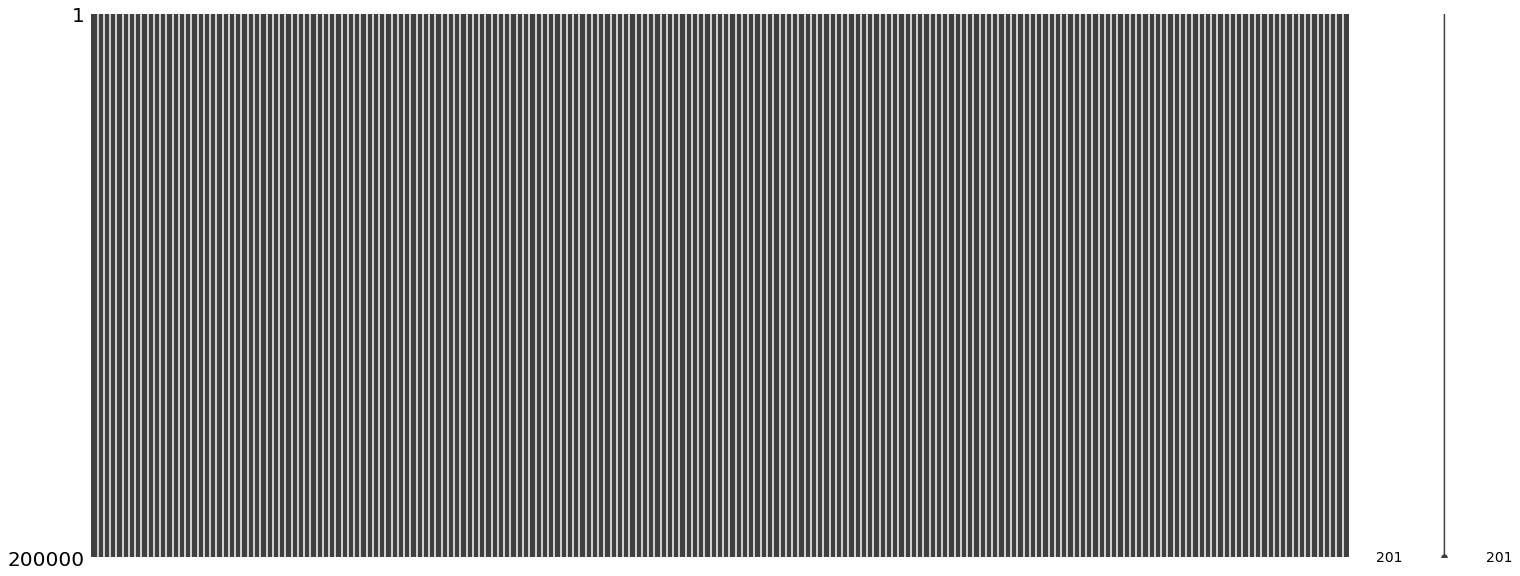

In [67]:
msno.matrix(test)

In [68]:
len(test) - test.count()

ID_code    0
var_0      0
var_1      0
var_2      0
var_3      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 201, dtype: int64

Выводы по пункту 1:
* train = 200000 rows, 202 cols
* test = 200000 rows, 201 cols
* Все признаки числовые, кроме одного строкового поля ID_code
* На трейне у нас одна только дискретная величина - это таргет, на тесте у нас дискретных величин нет
* Все 200 непрерывных признака распределены почти нормально, просто каждый имеет свое смещение относительно 0.
* Пропусков в данных нет


### 2. Базовый анализ целевой переменной

In [73]:
target = train["target"]
target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

Целевая переменная имеет только два уникальных значения - это 0 и 1. Причем количество наблюдений с классом 0 преобладает

### 3. Распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки

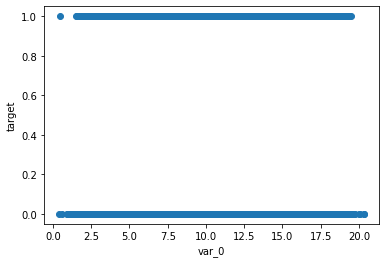

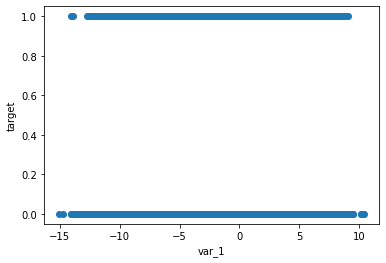

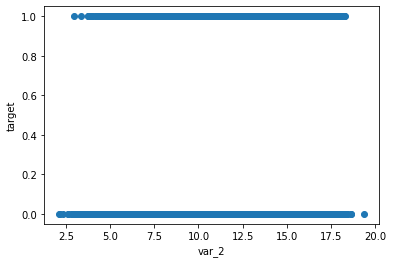

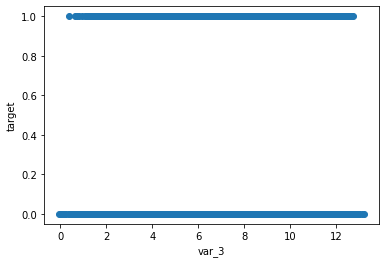

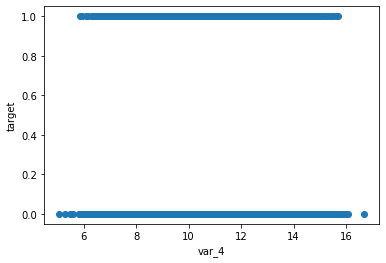

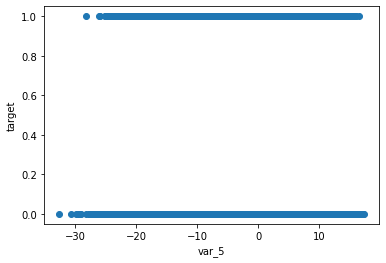

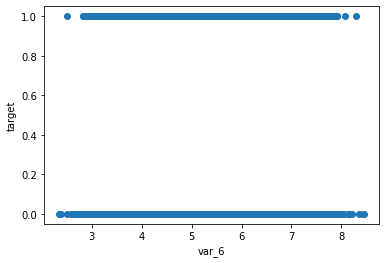

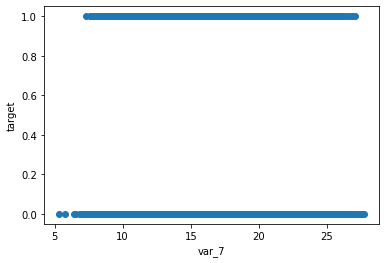

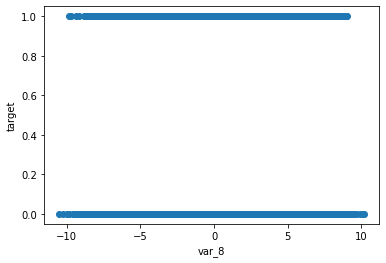

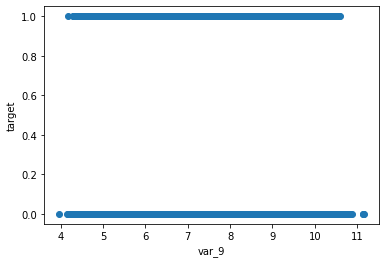

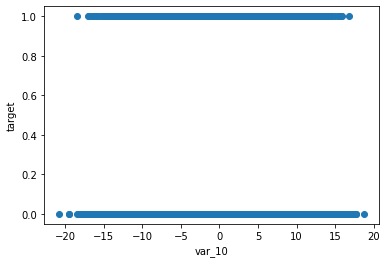

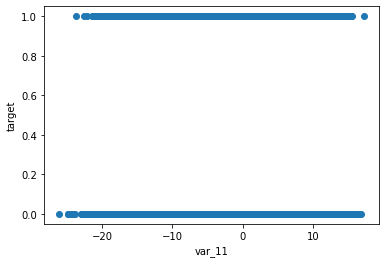

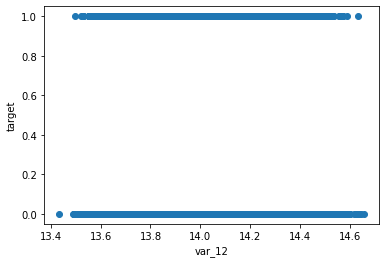

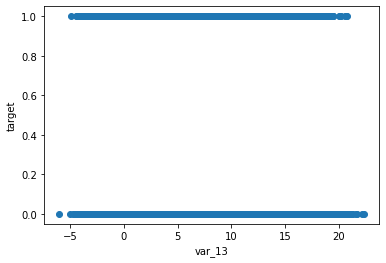

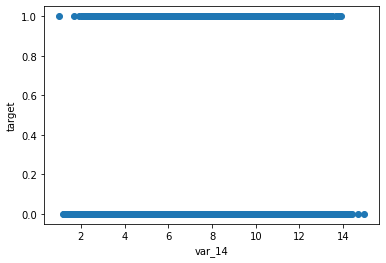

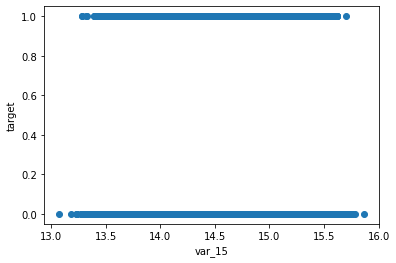

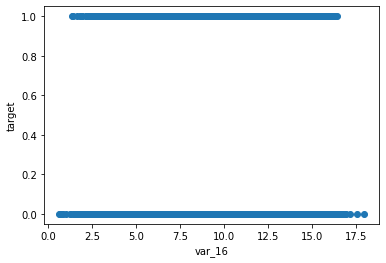

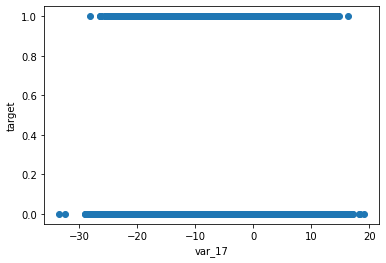

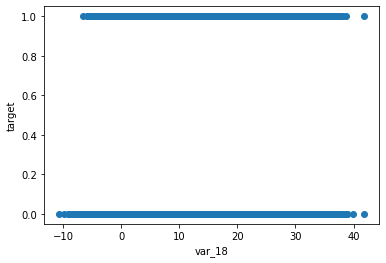

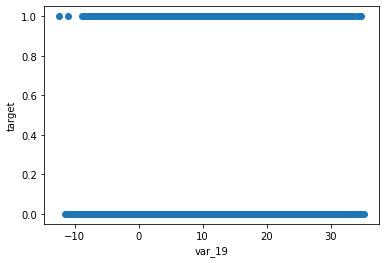

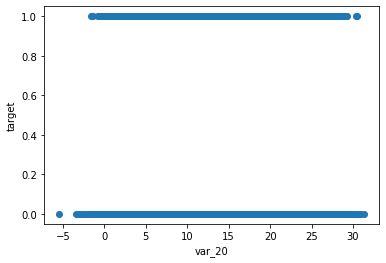

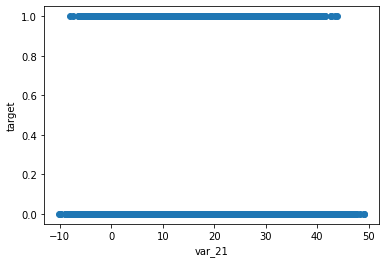

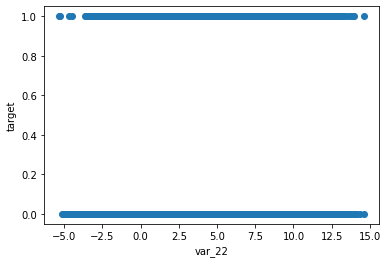

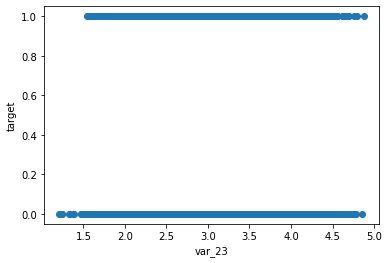

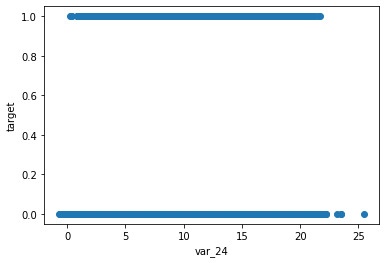

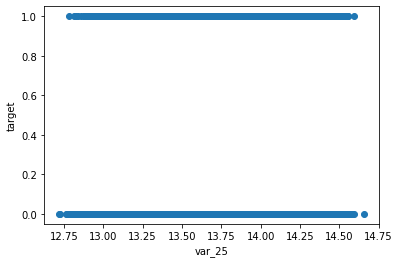

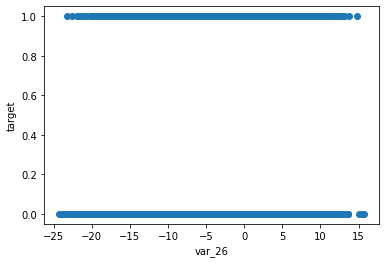

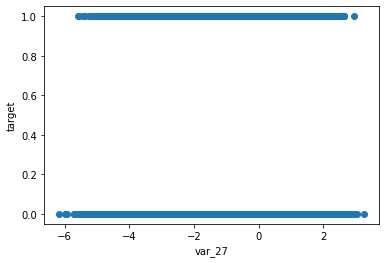

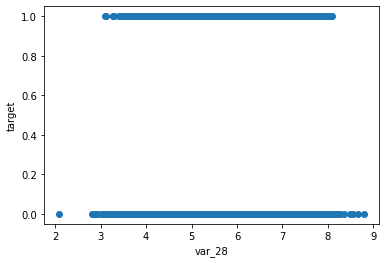

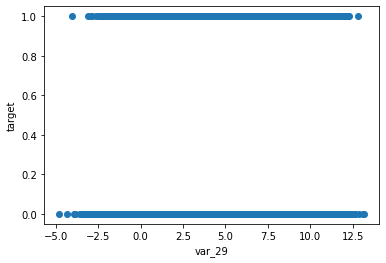

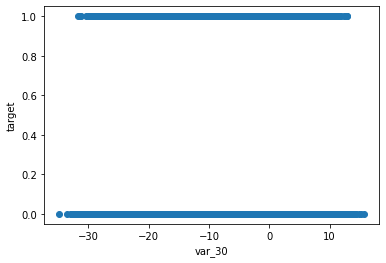

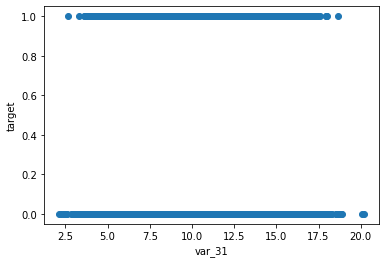

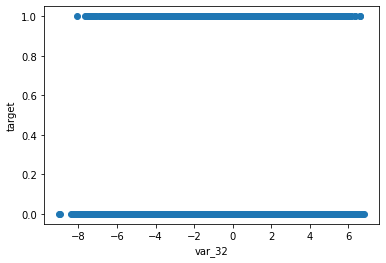

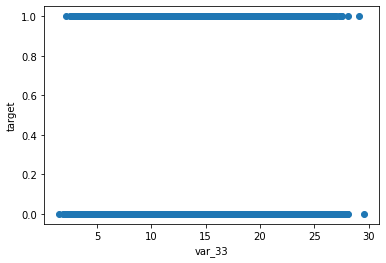

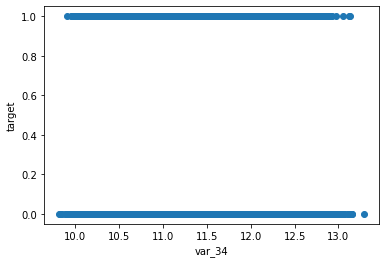

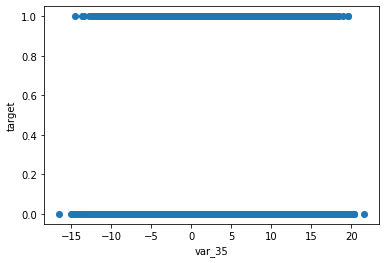

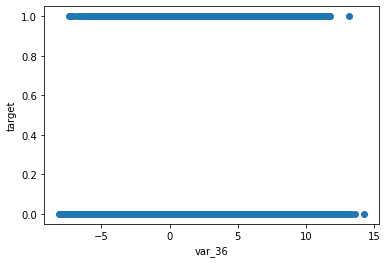

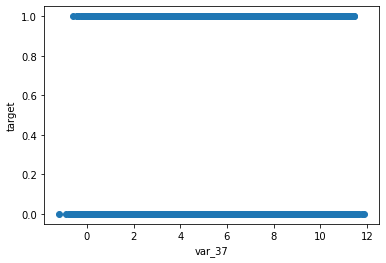

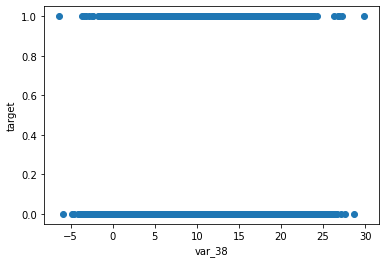

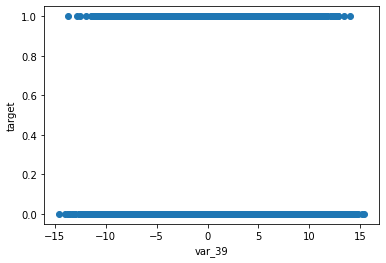

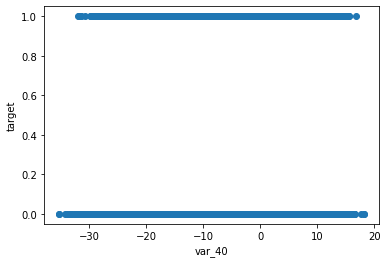

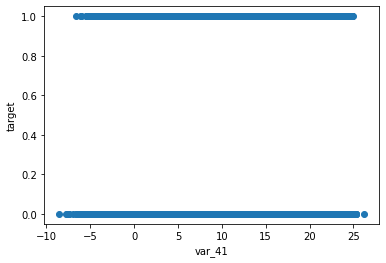

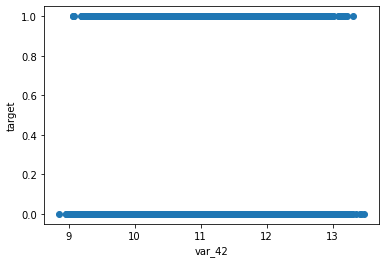

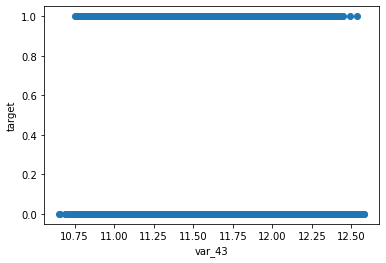

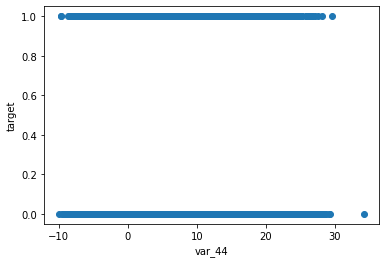

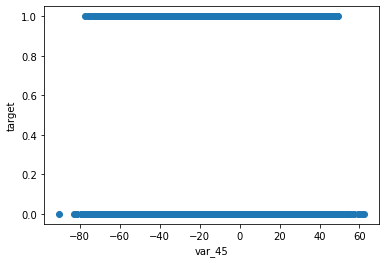

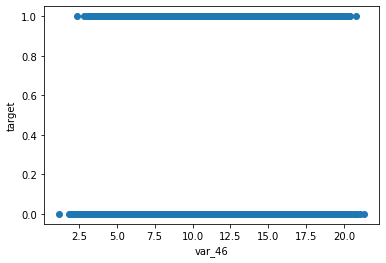

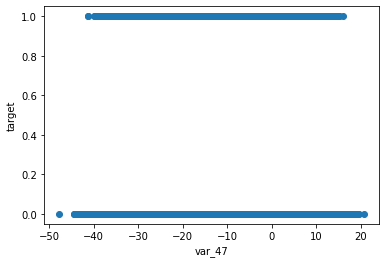

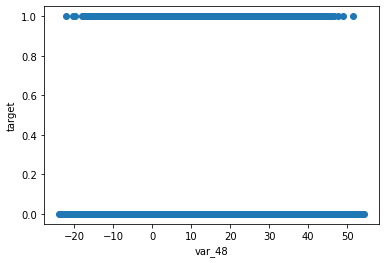

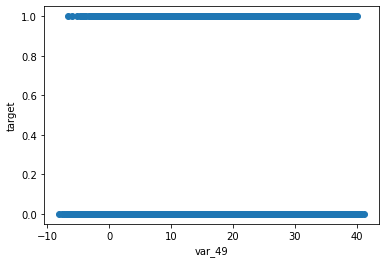

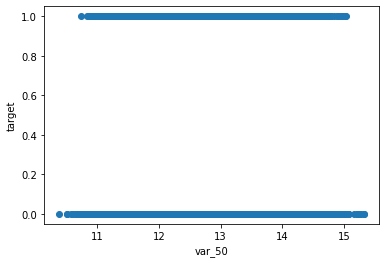

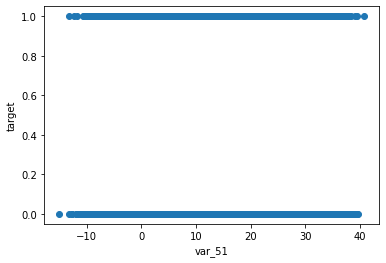

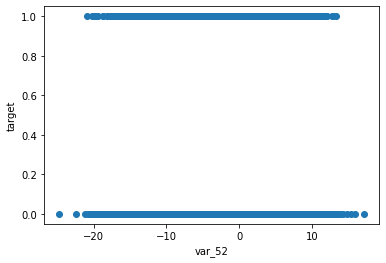

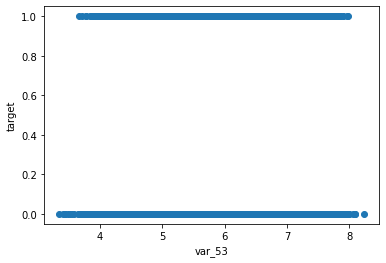

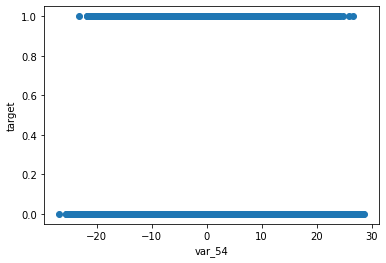

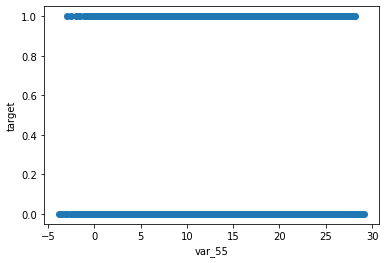

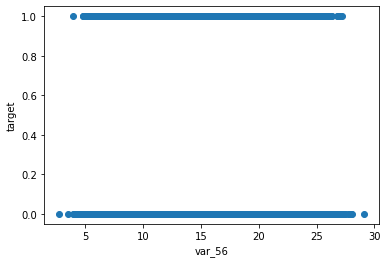

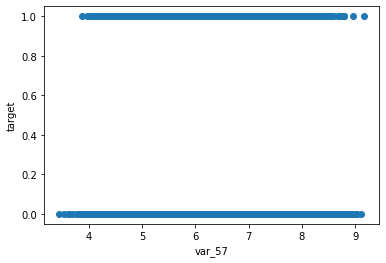

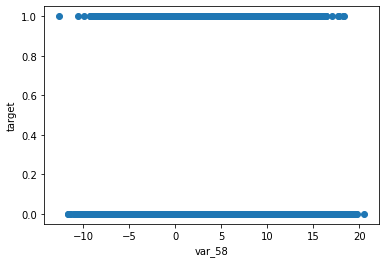

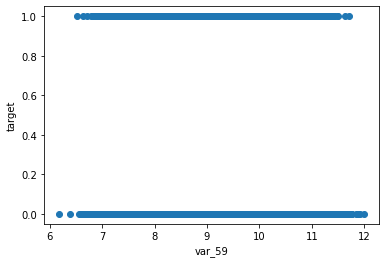

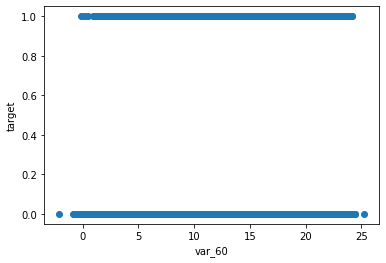

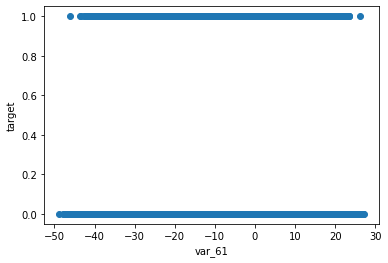

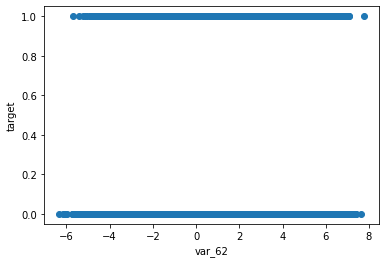

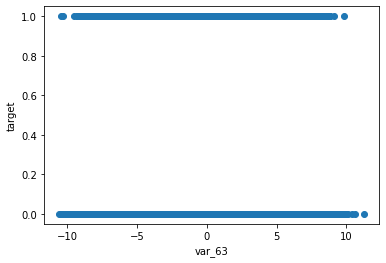

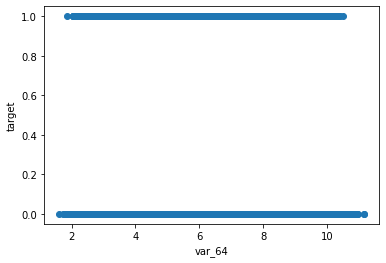

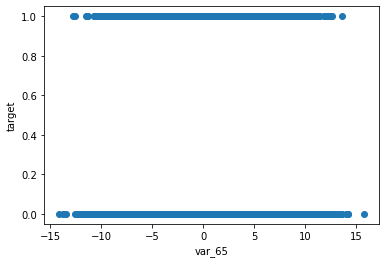

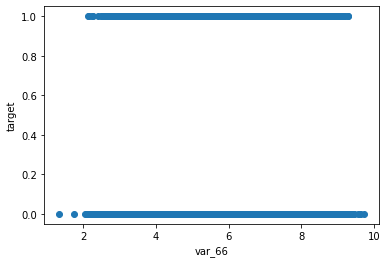

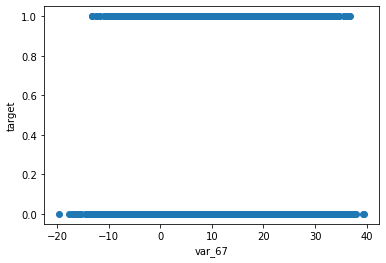

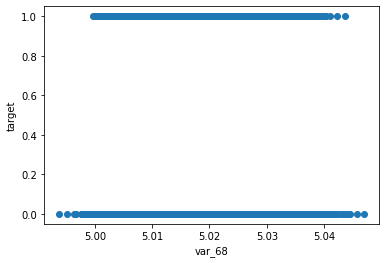

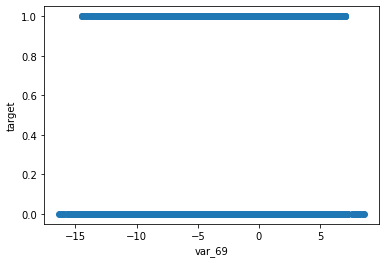

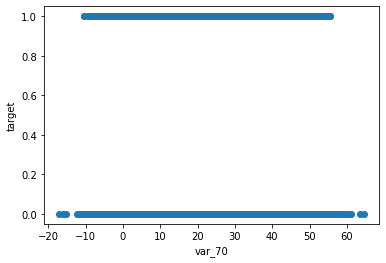

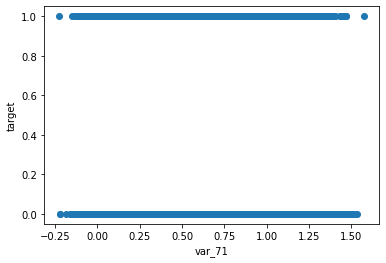

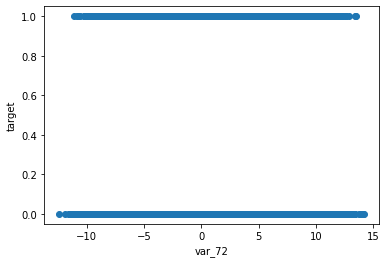

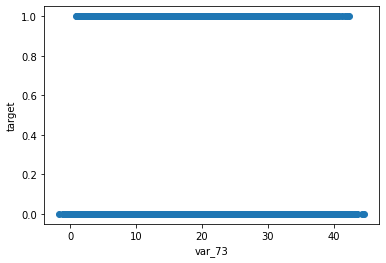

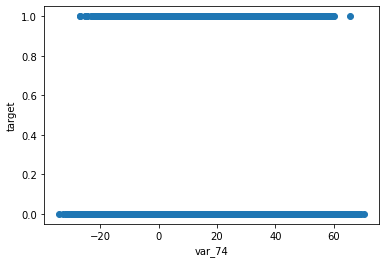

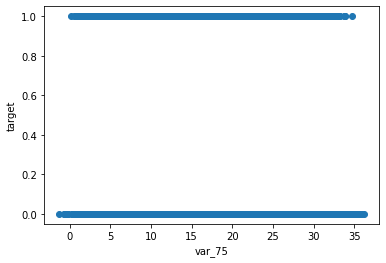

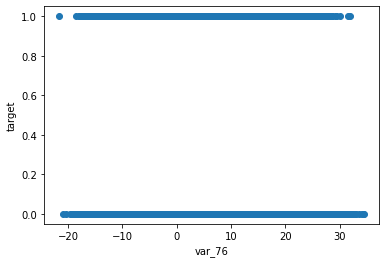

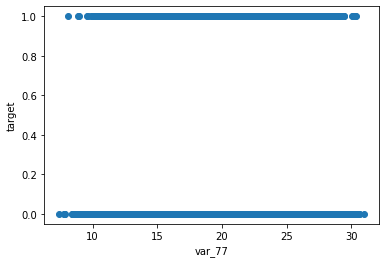

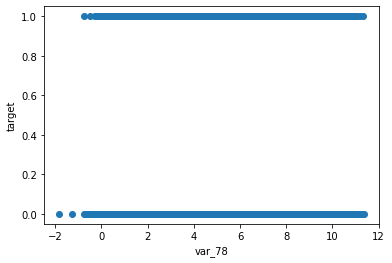

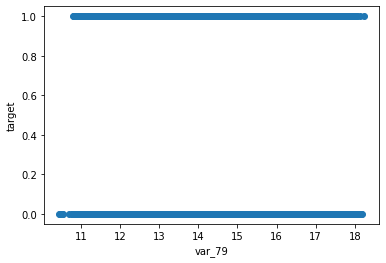

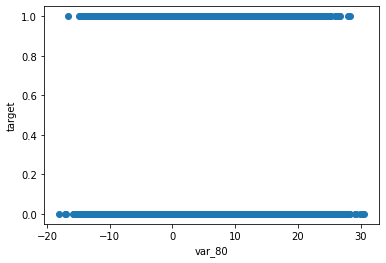

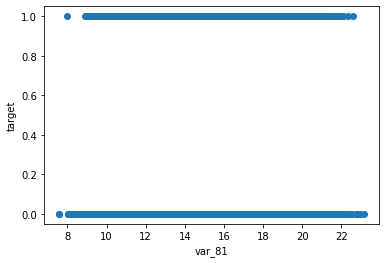

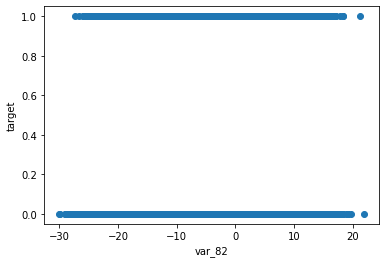

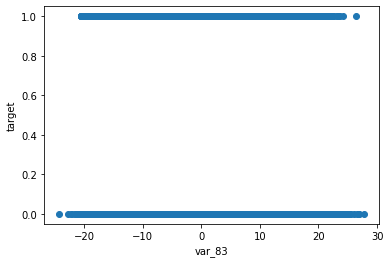

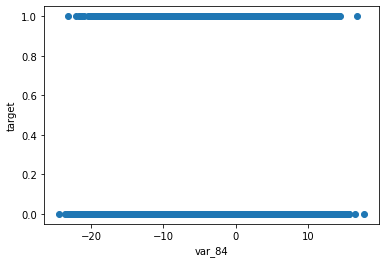

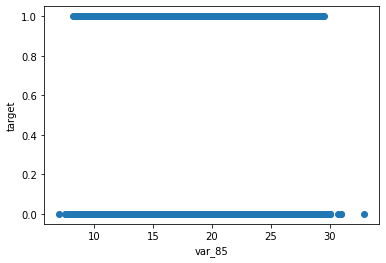

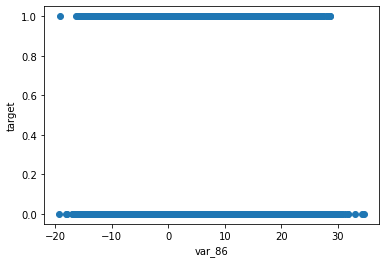

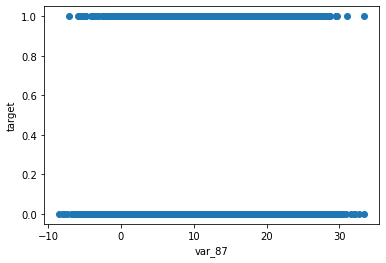

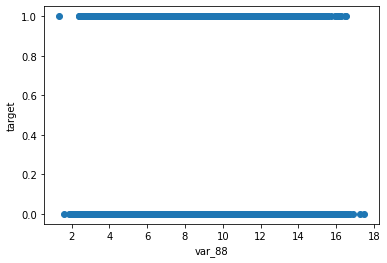

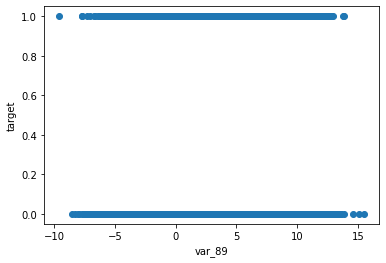

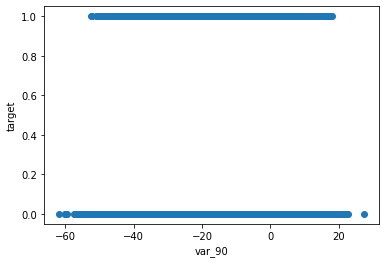

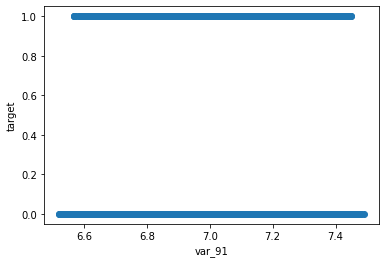

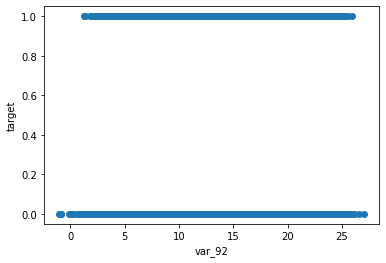

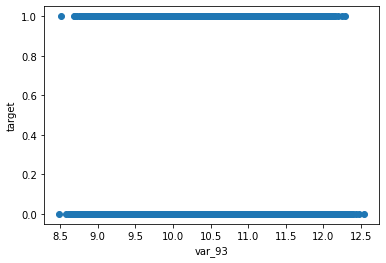

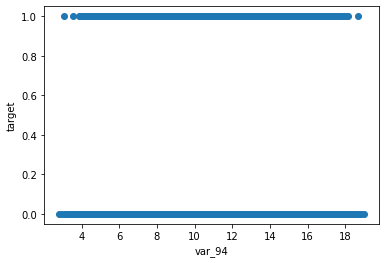

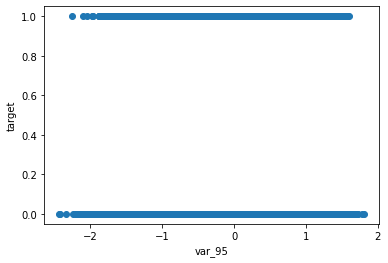

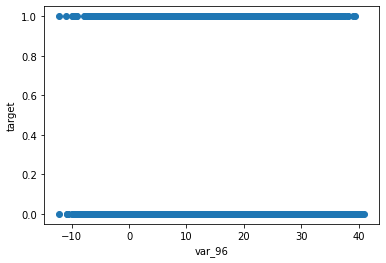

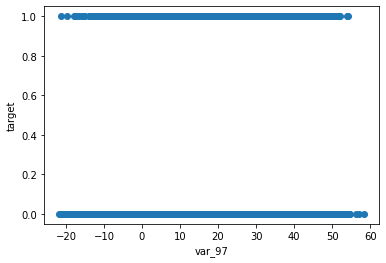

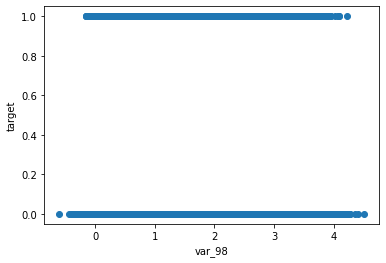

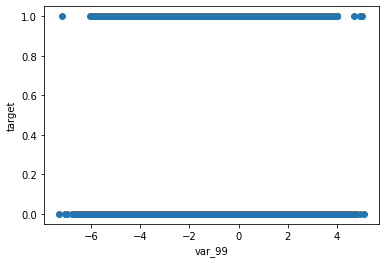

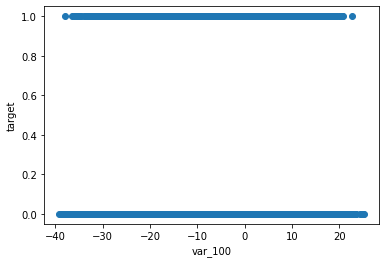

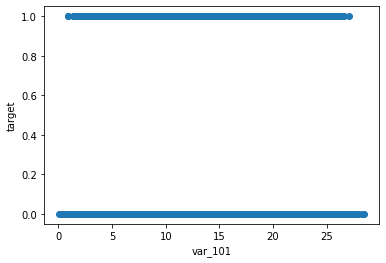

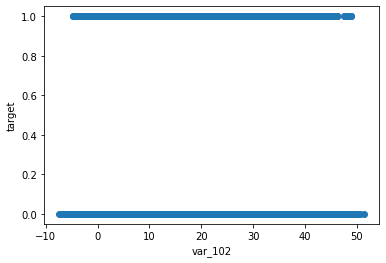

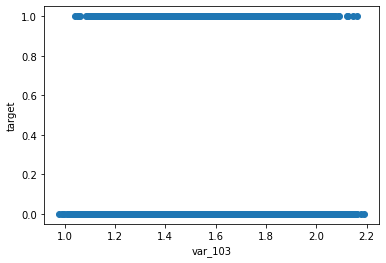

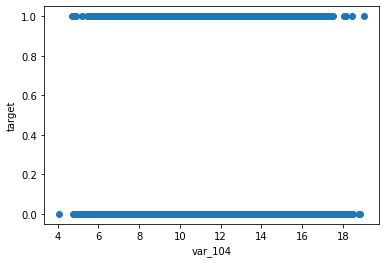

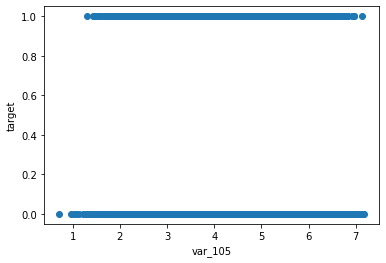

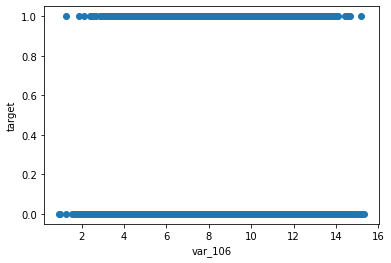

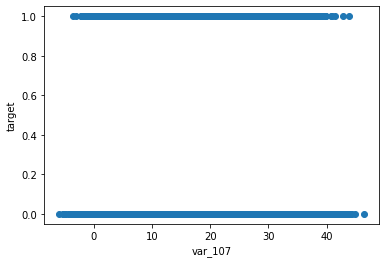

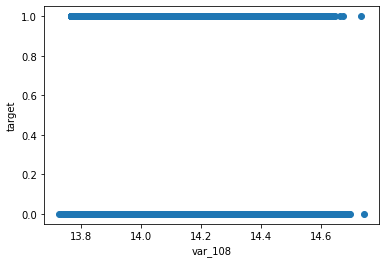

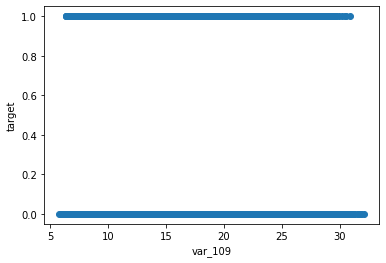

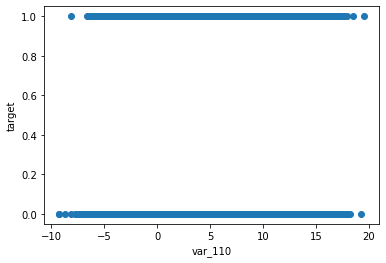

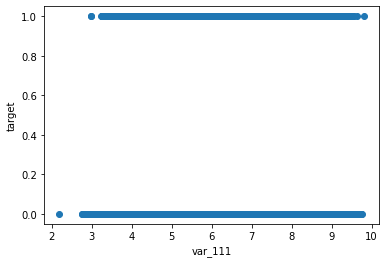

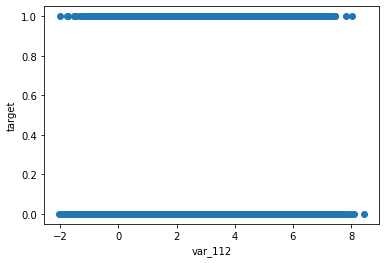

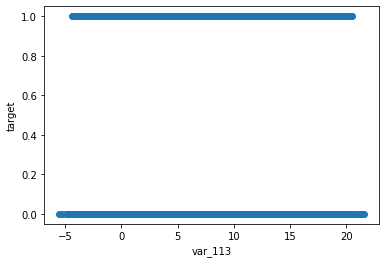

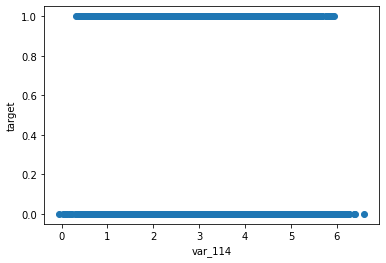

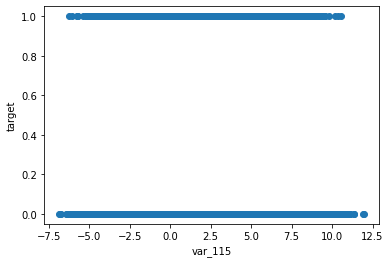

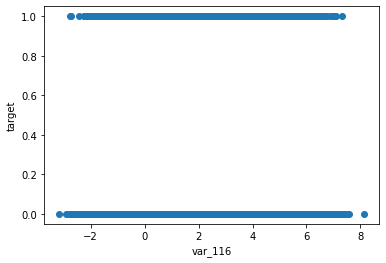

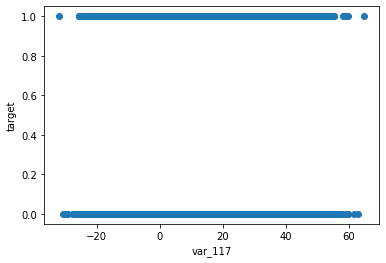

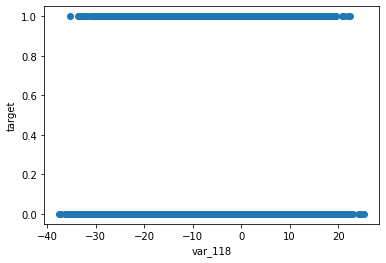

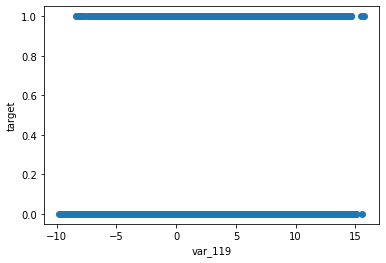

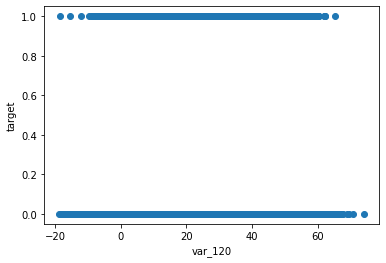

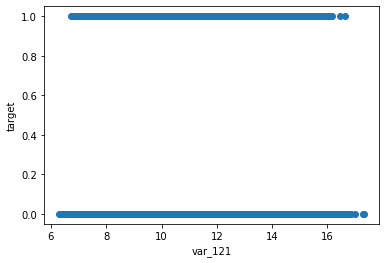

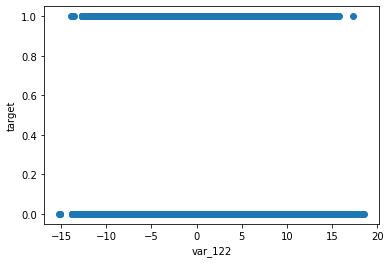

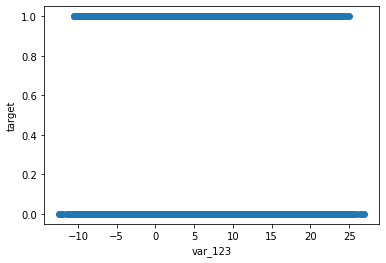

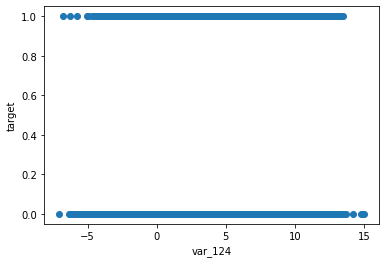

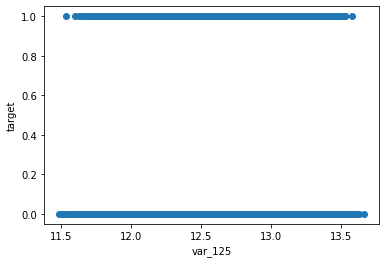

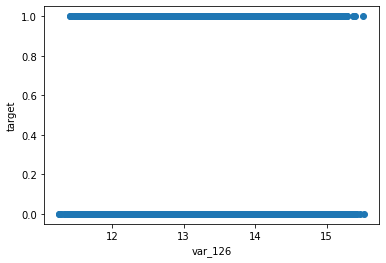

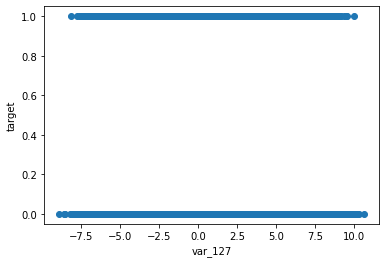

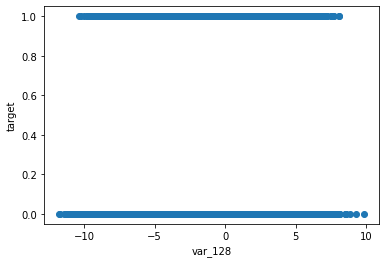

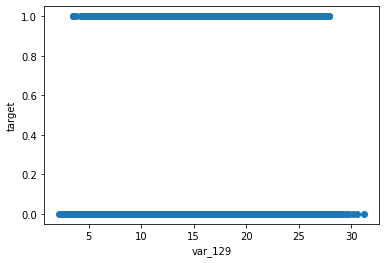

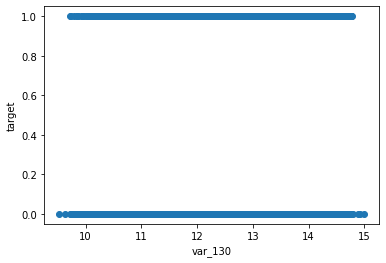

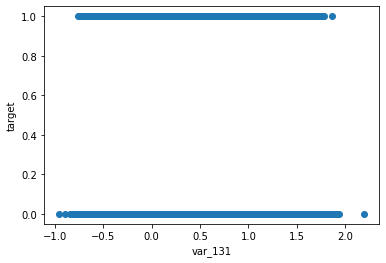

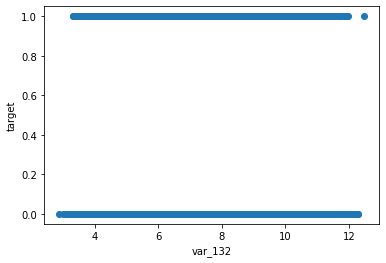

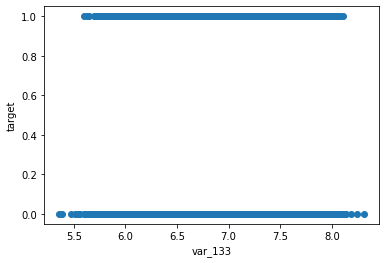

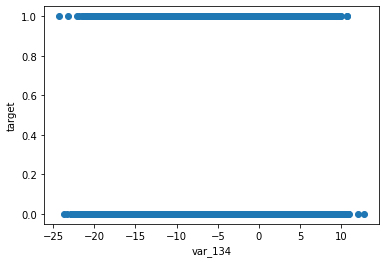

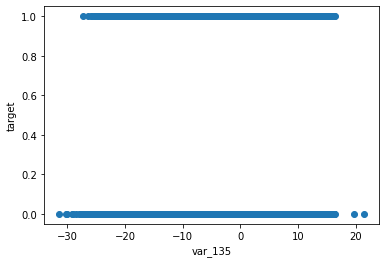

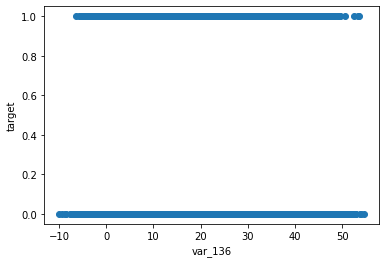

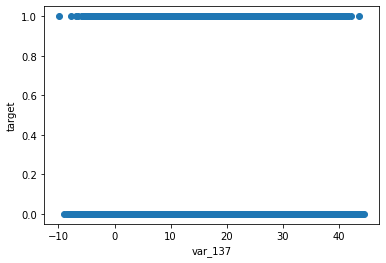

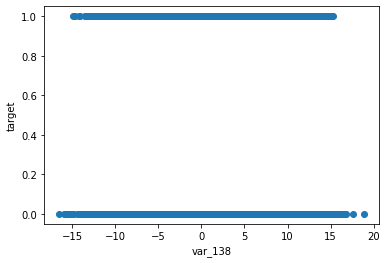

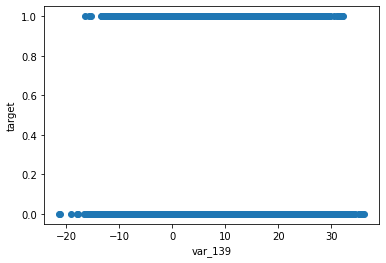

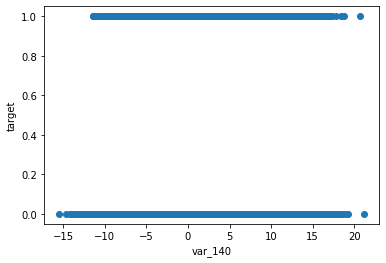

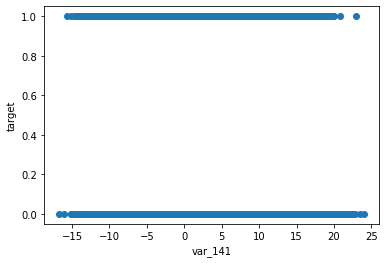

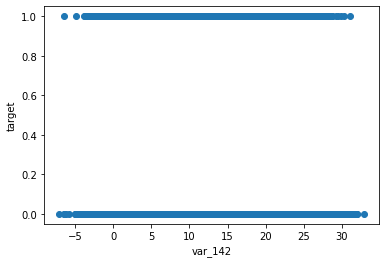

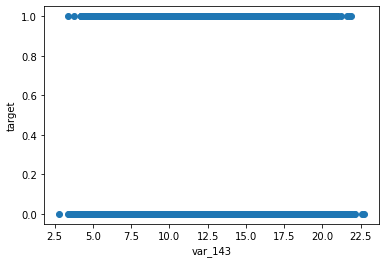

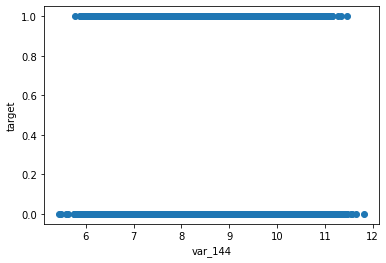

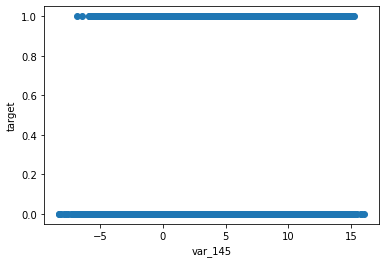

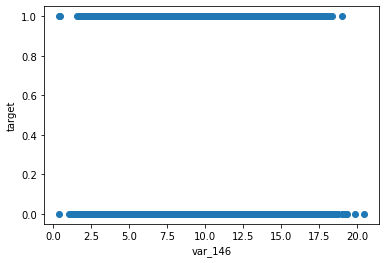

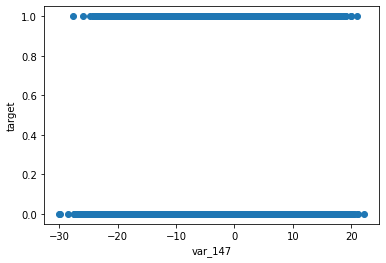

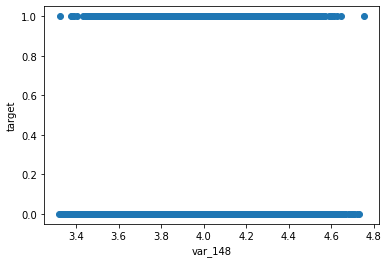

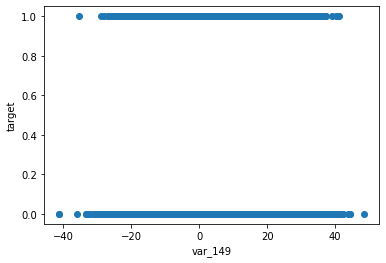

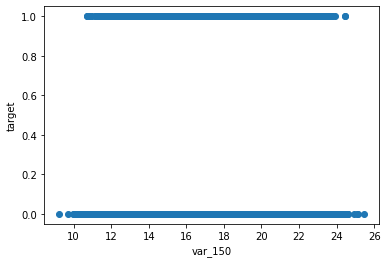

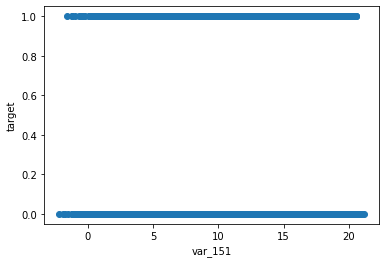

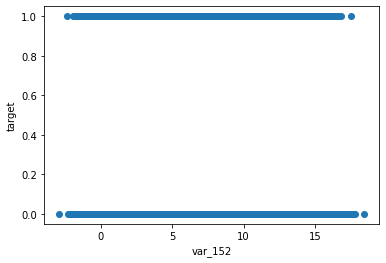

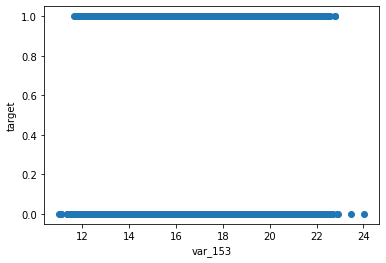

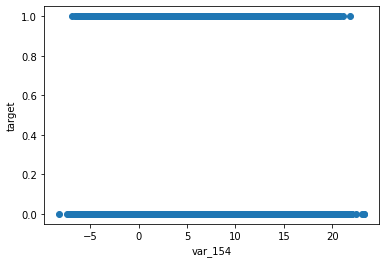

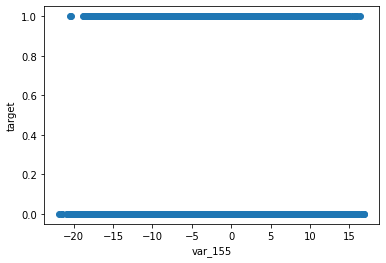

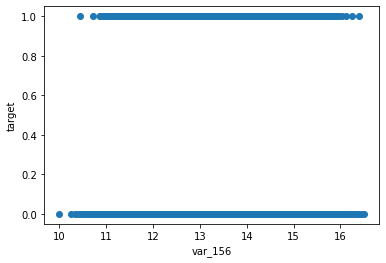

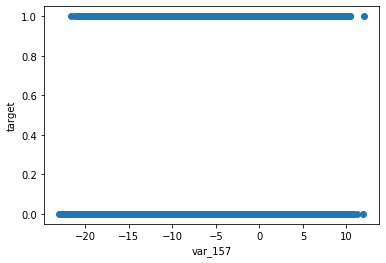

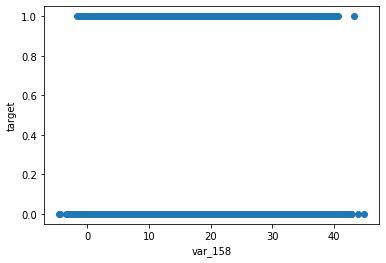

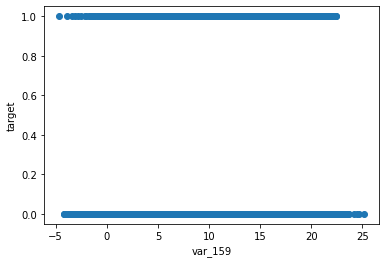

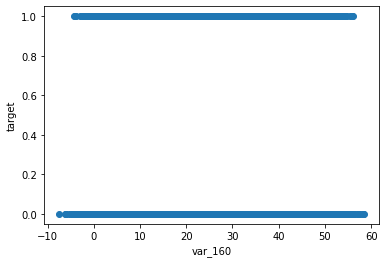

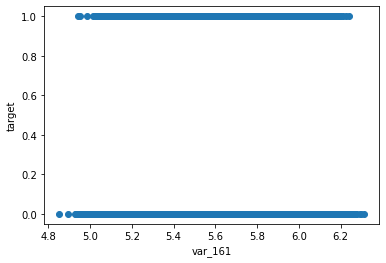

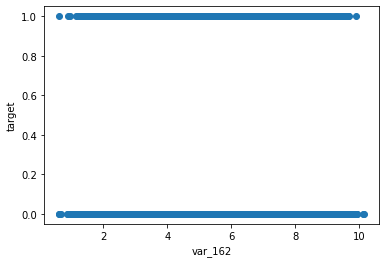

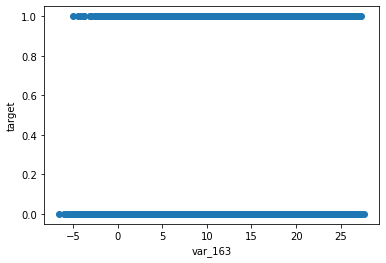

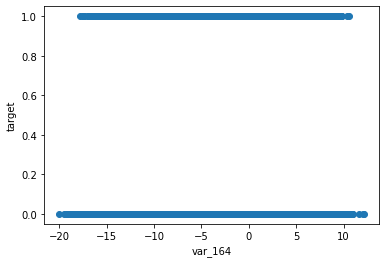

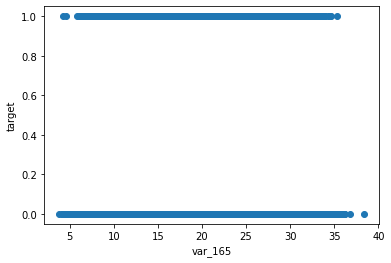

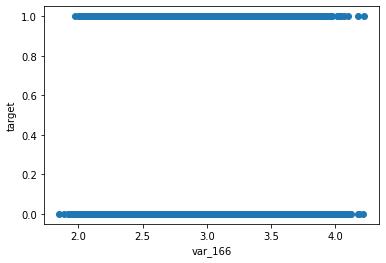

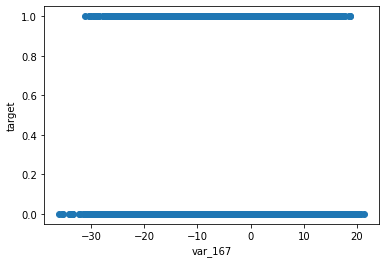

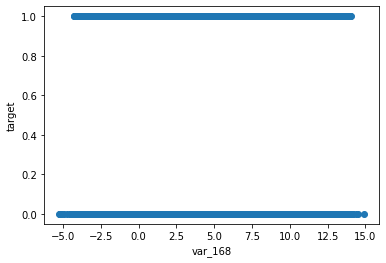

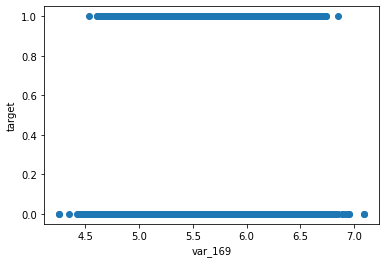

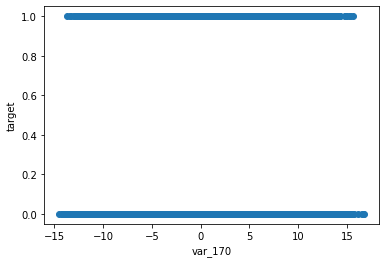

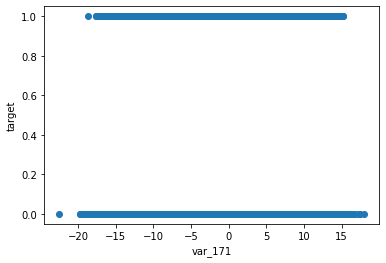

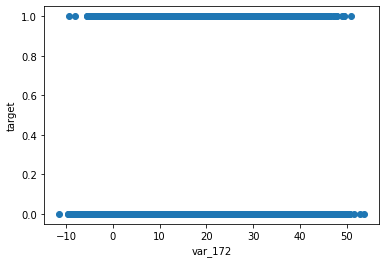

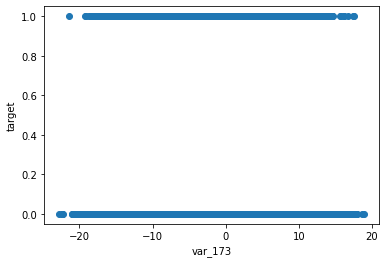

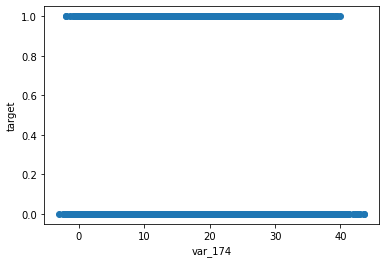

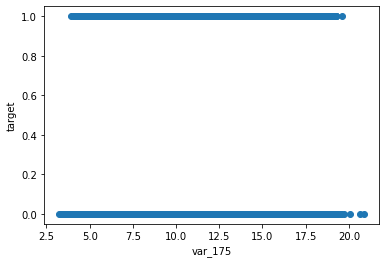

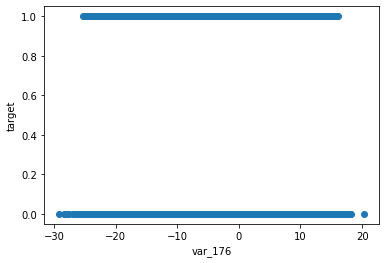

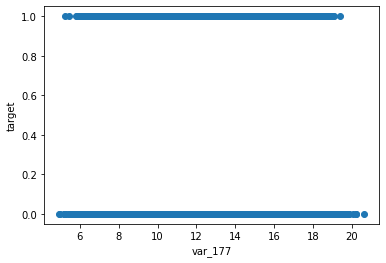

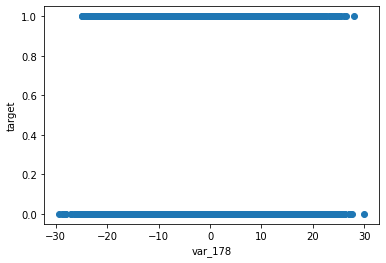

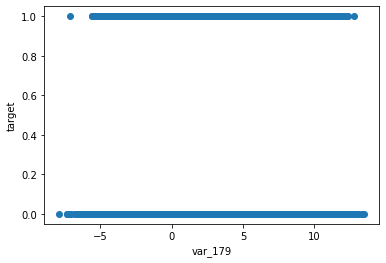

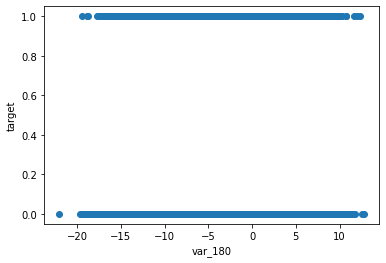

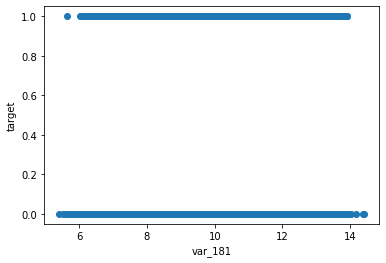

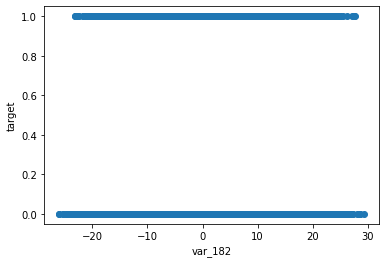

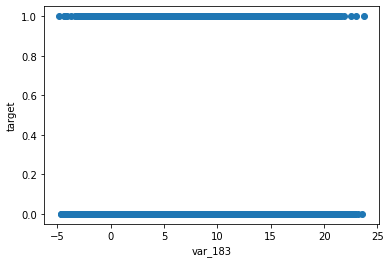

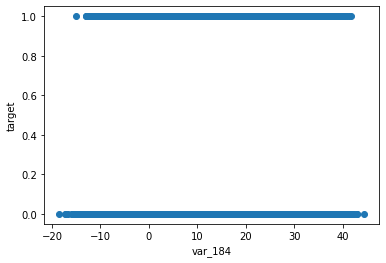

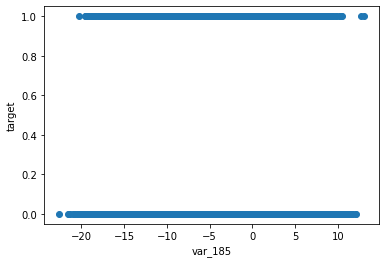

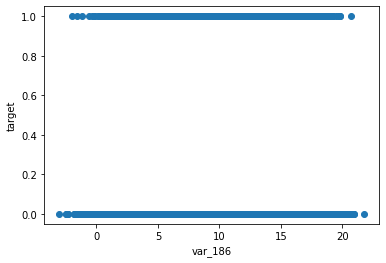

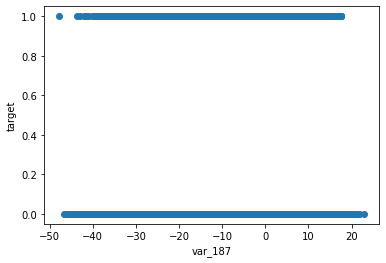

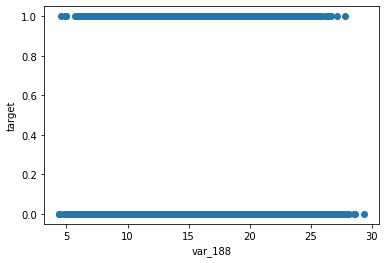

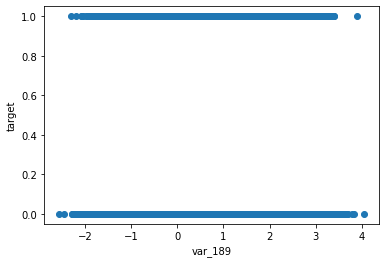

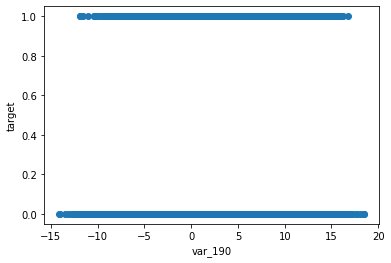

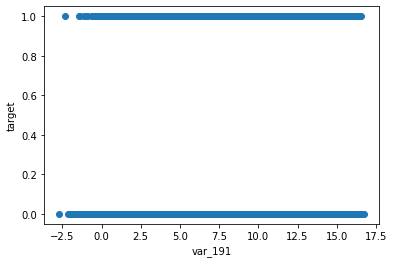

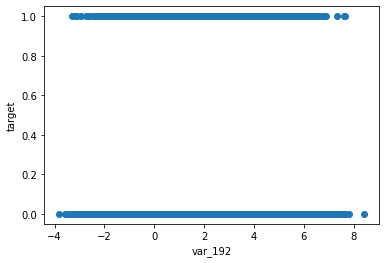

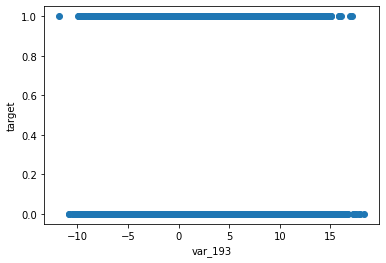

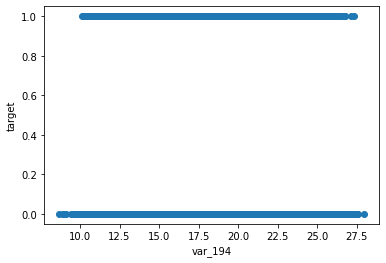

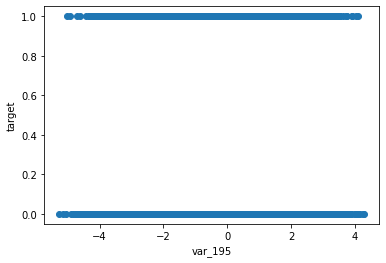

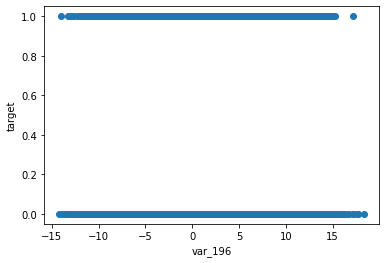

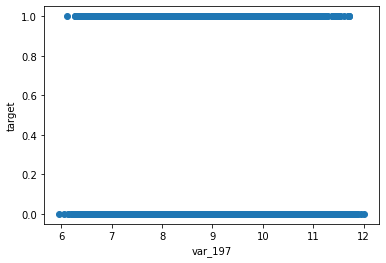

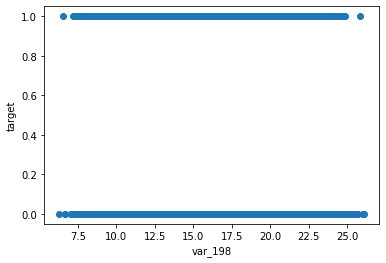

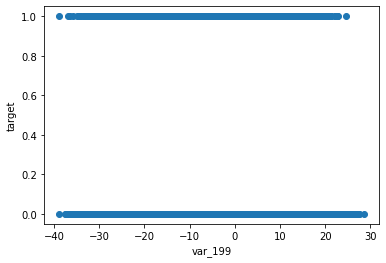

In [85]:
for num, feature in enumerate(continuous_feature):
    plt.scatter(train[feature], train['target']) 
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.show()

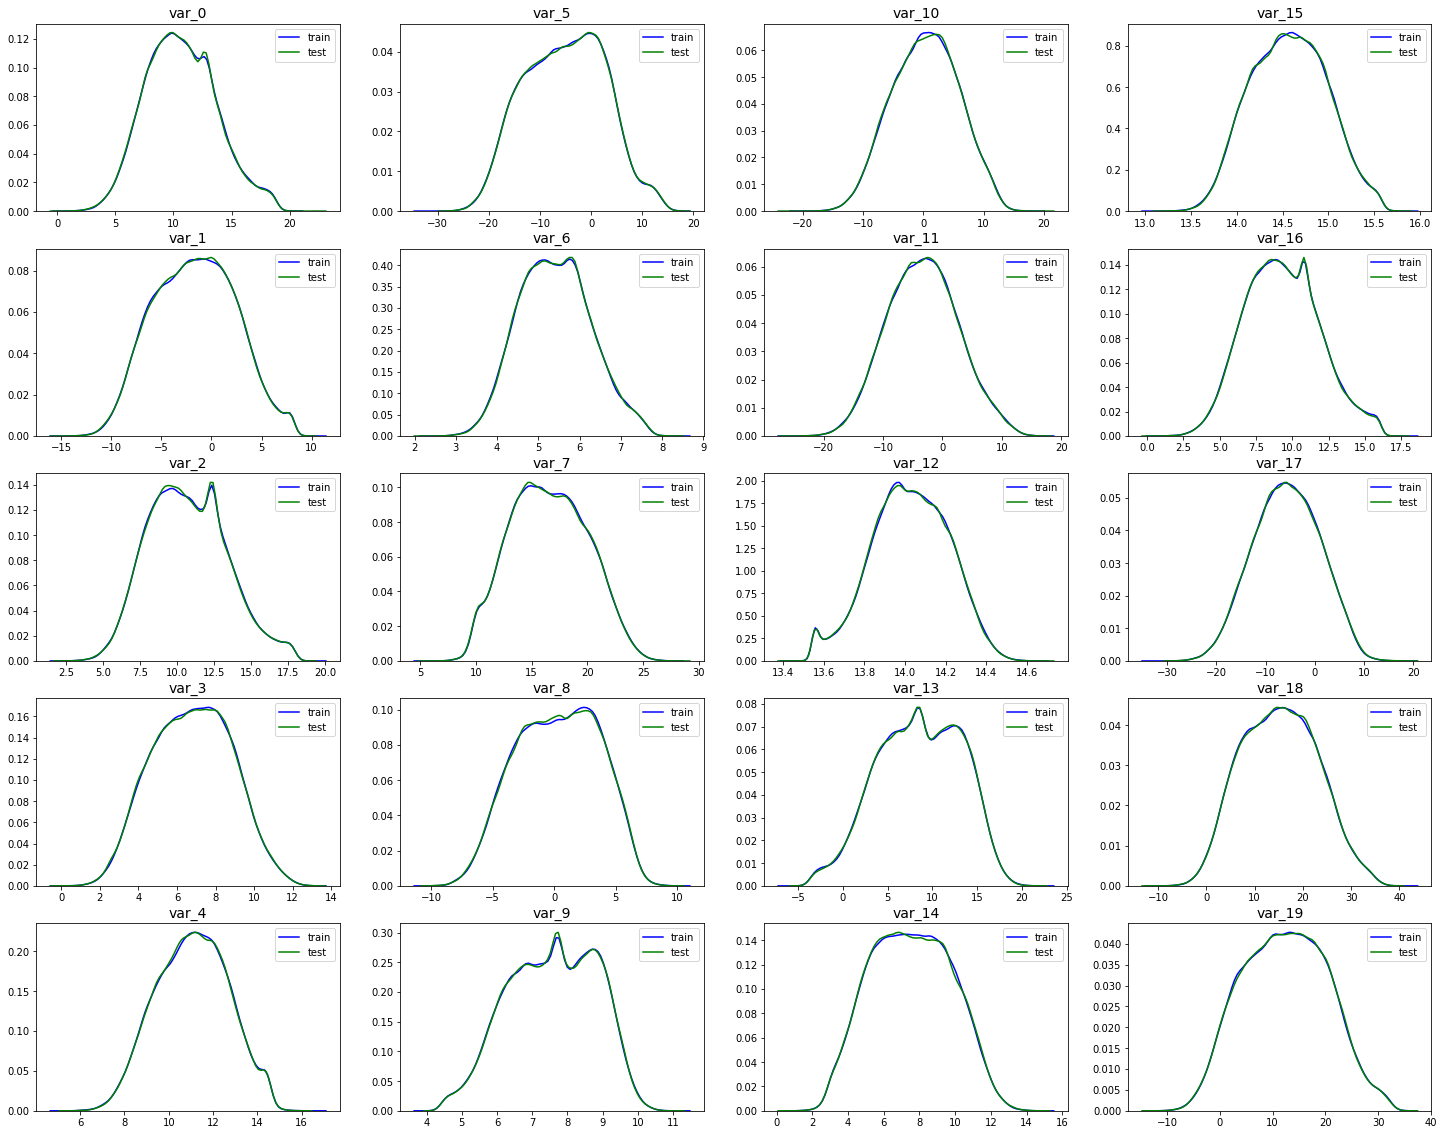

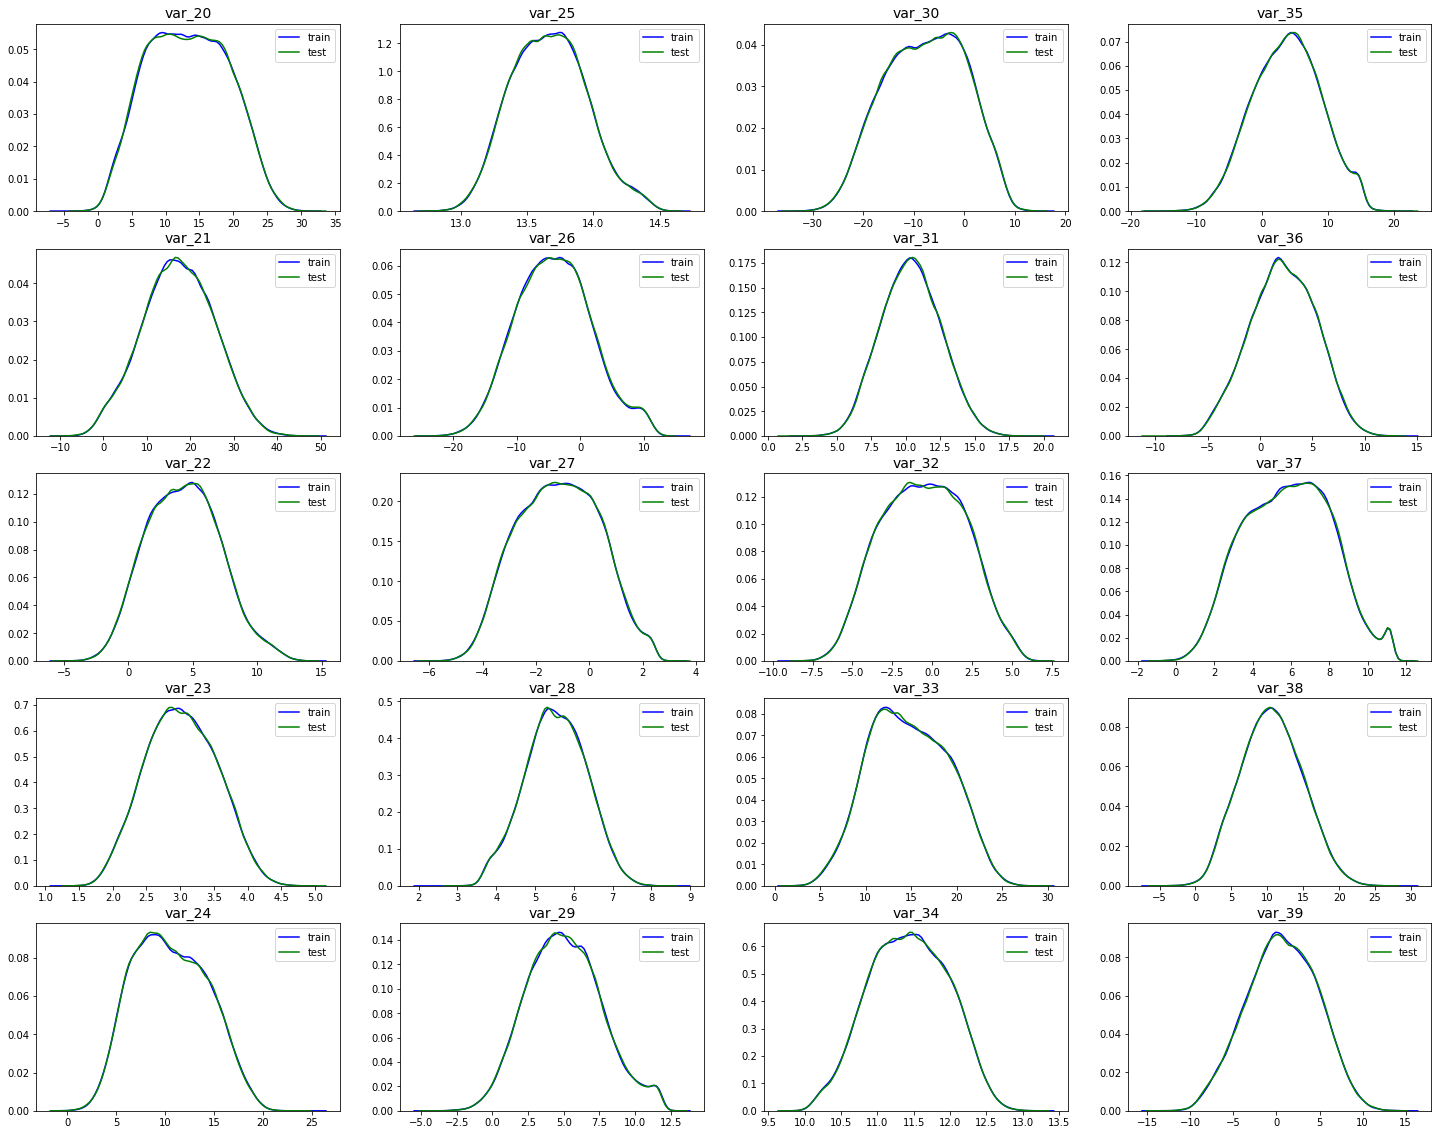

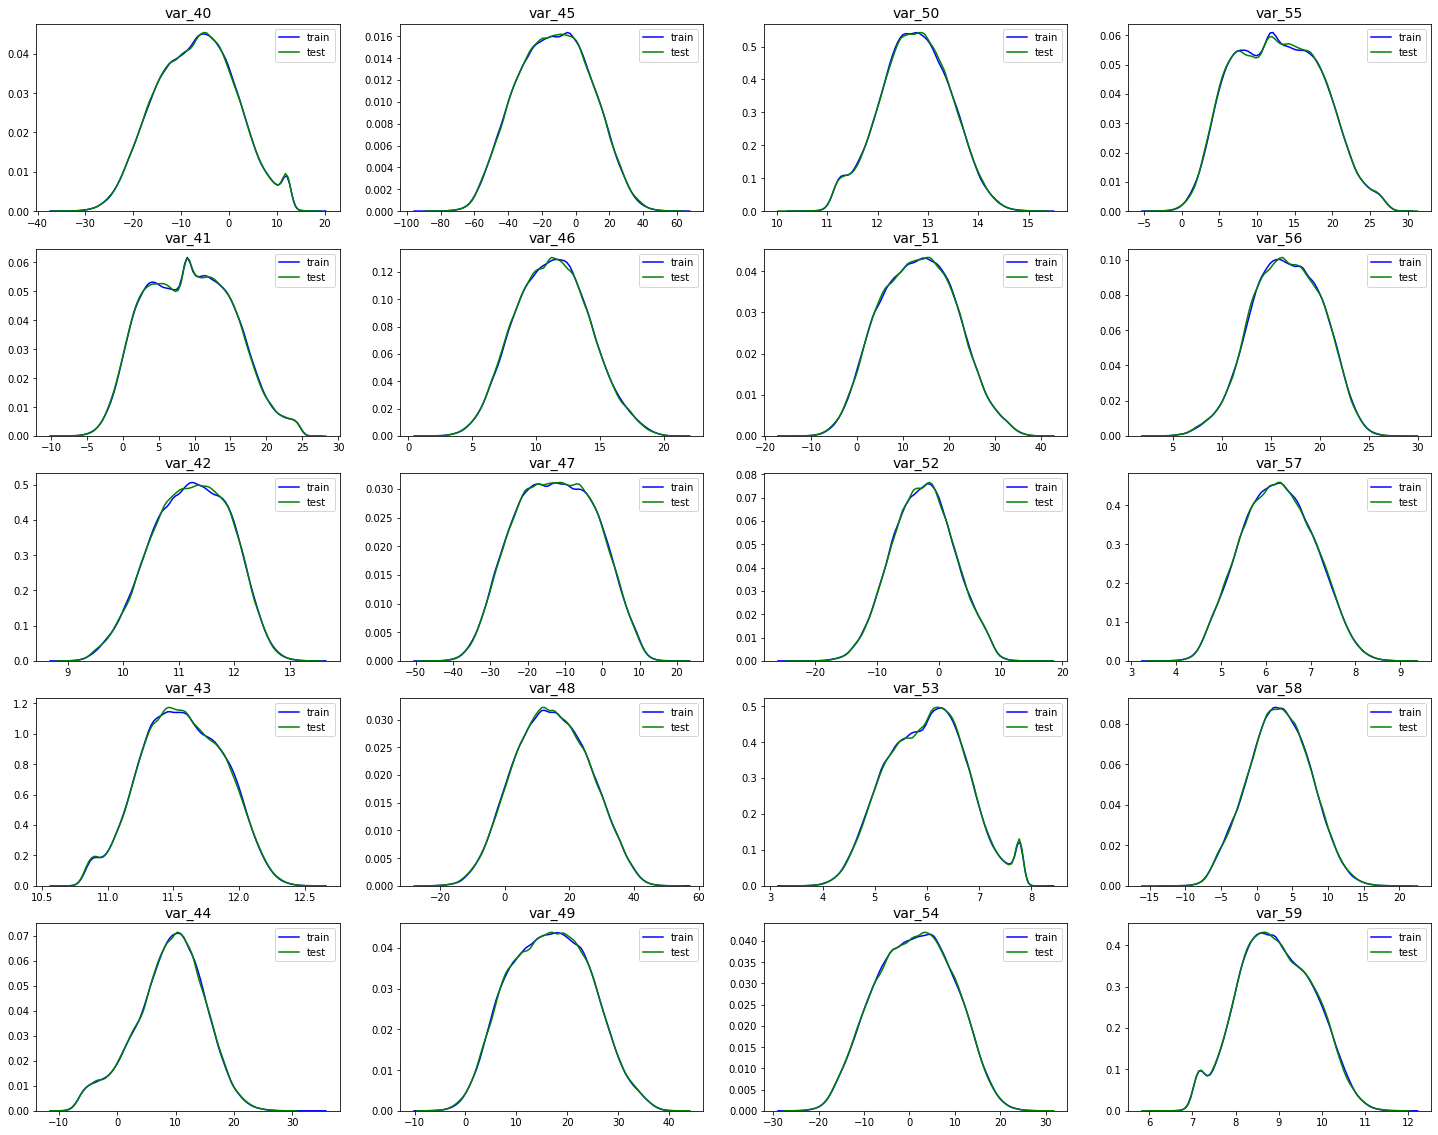

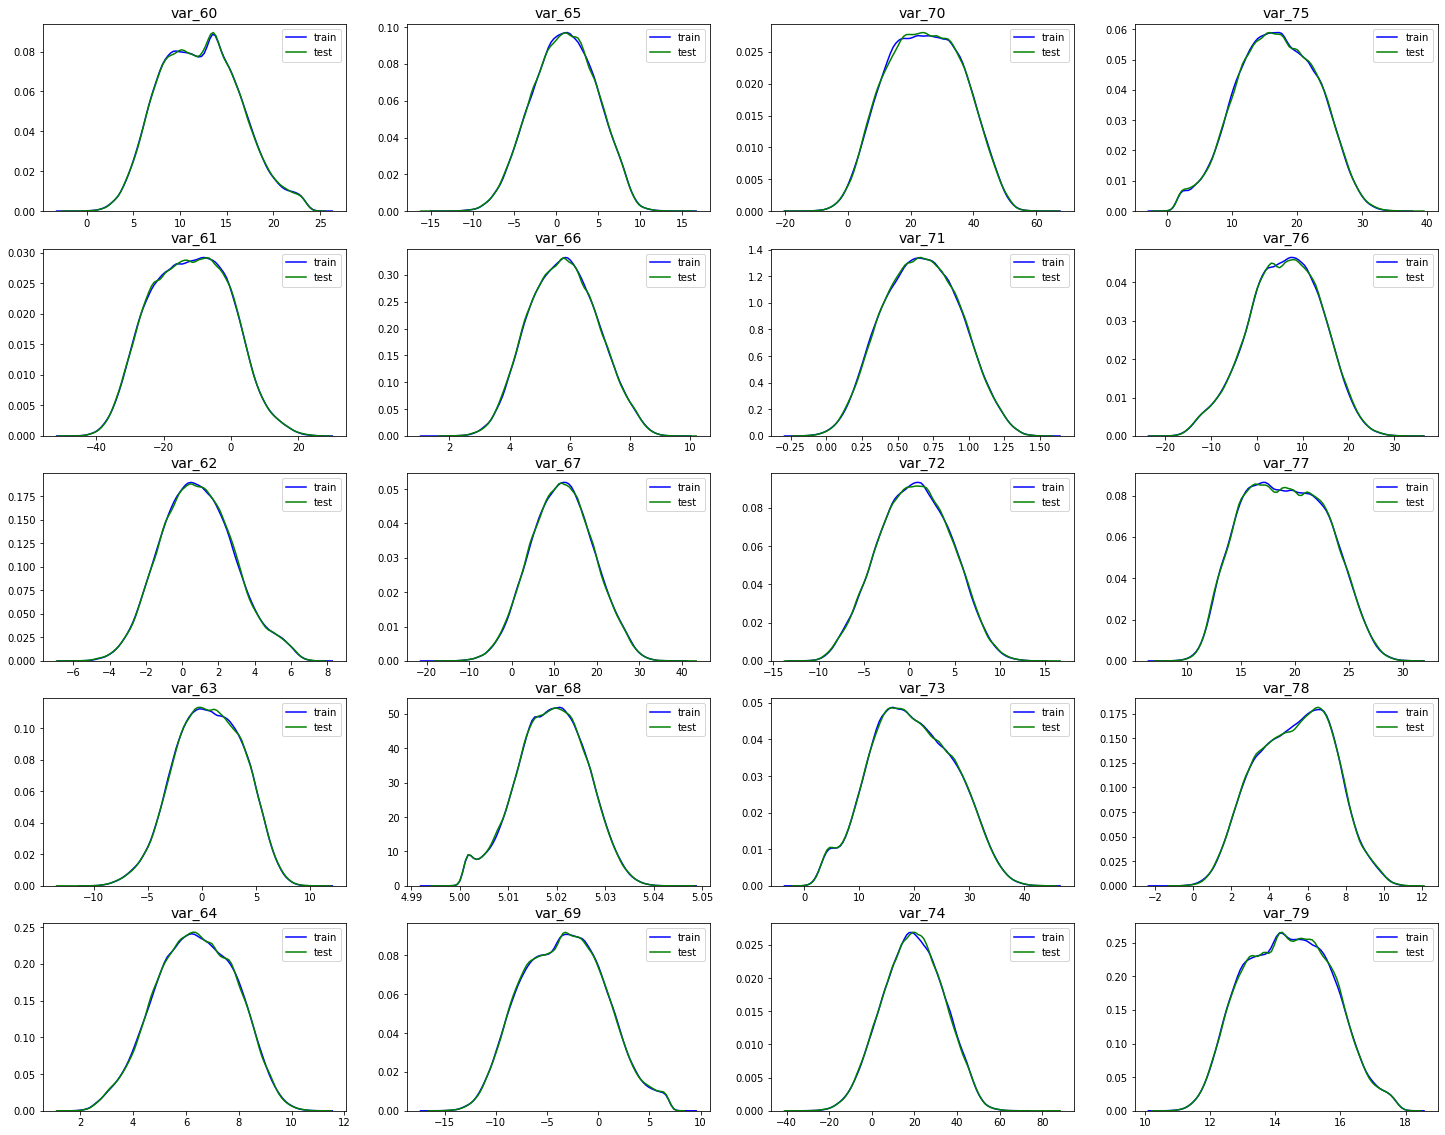

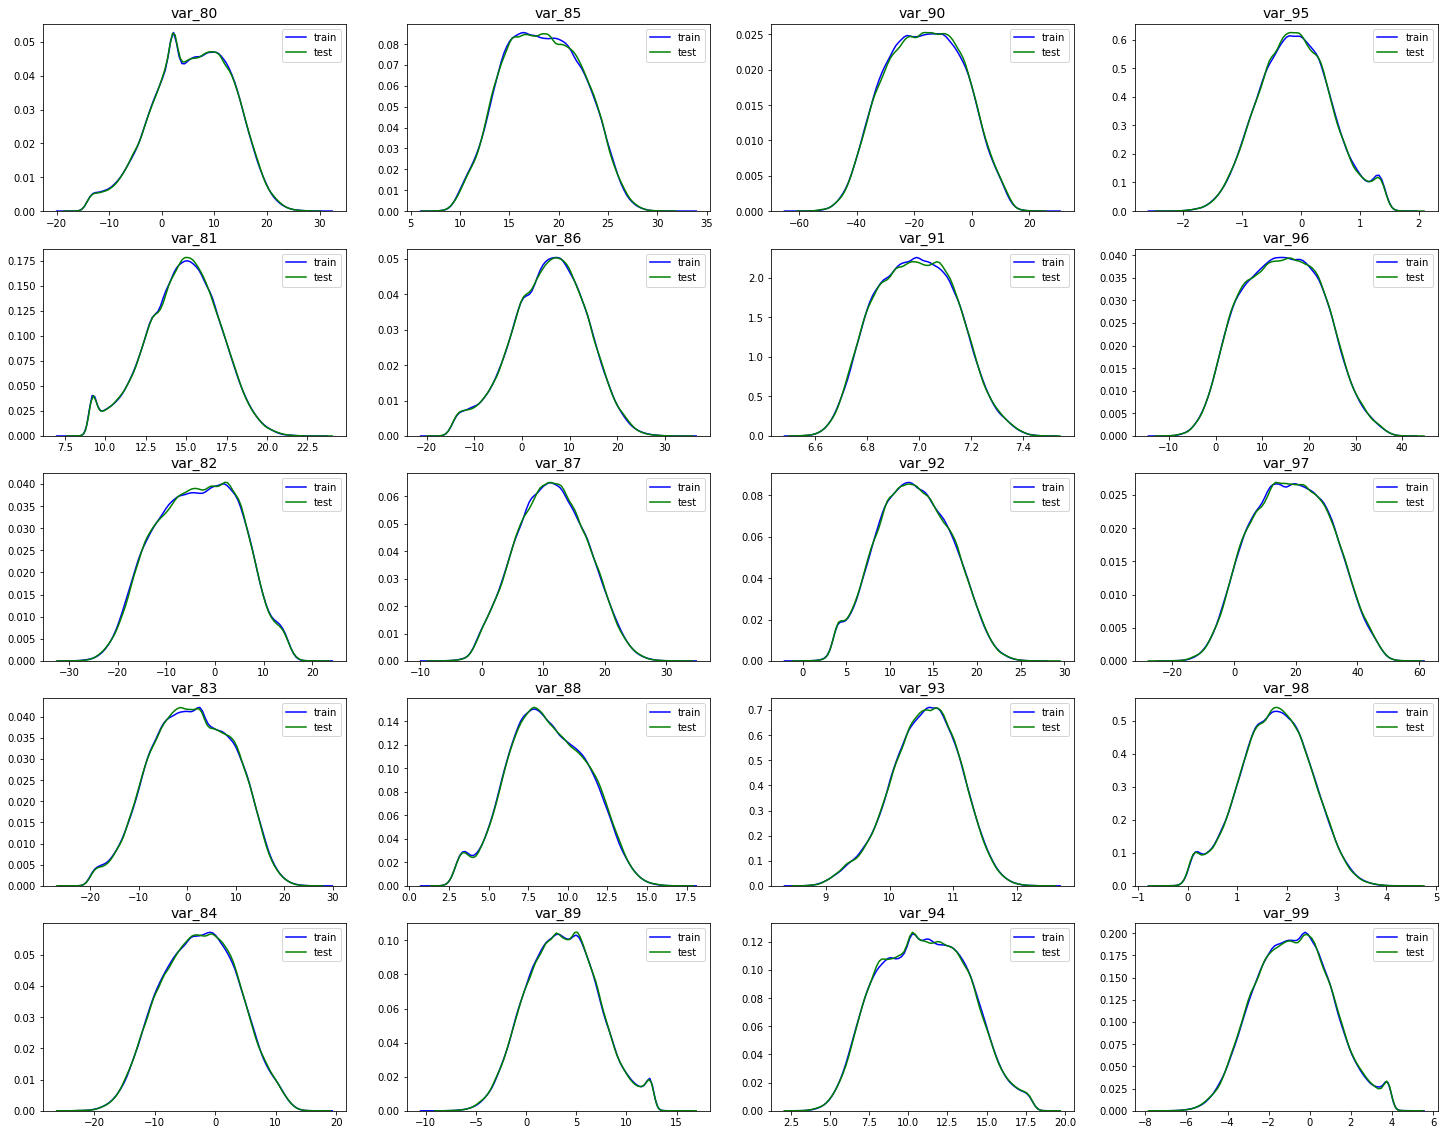

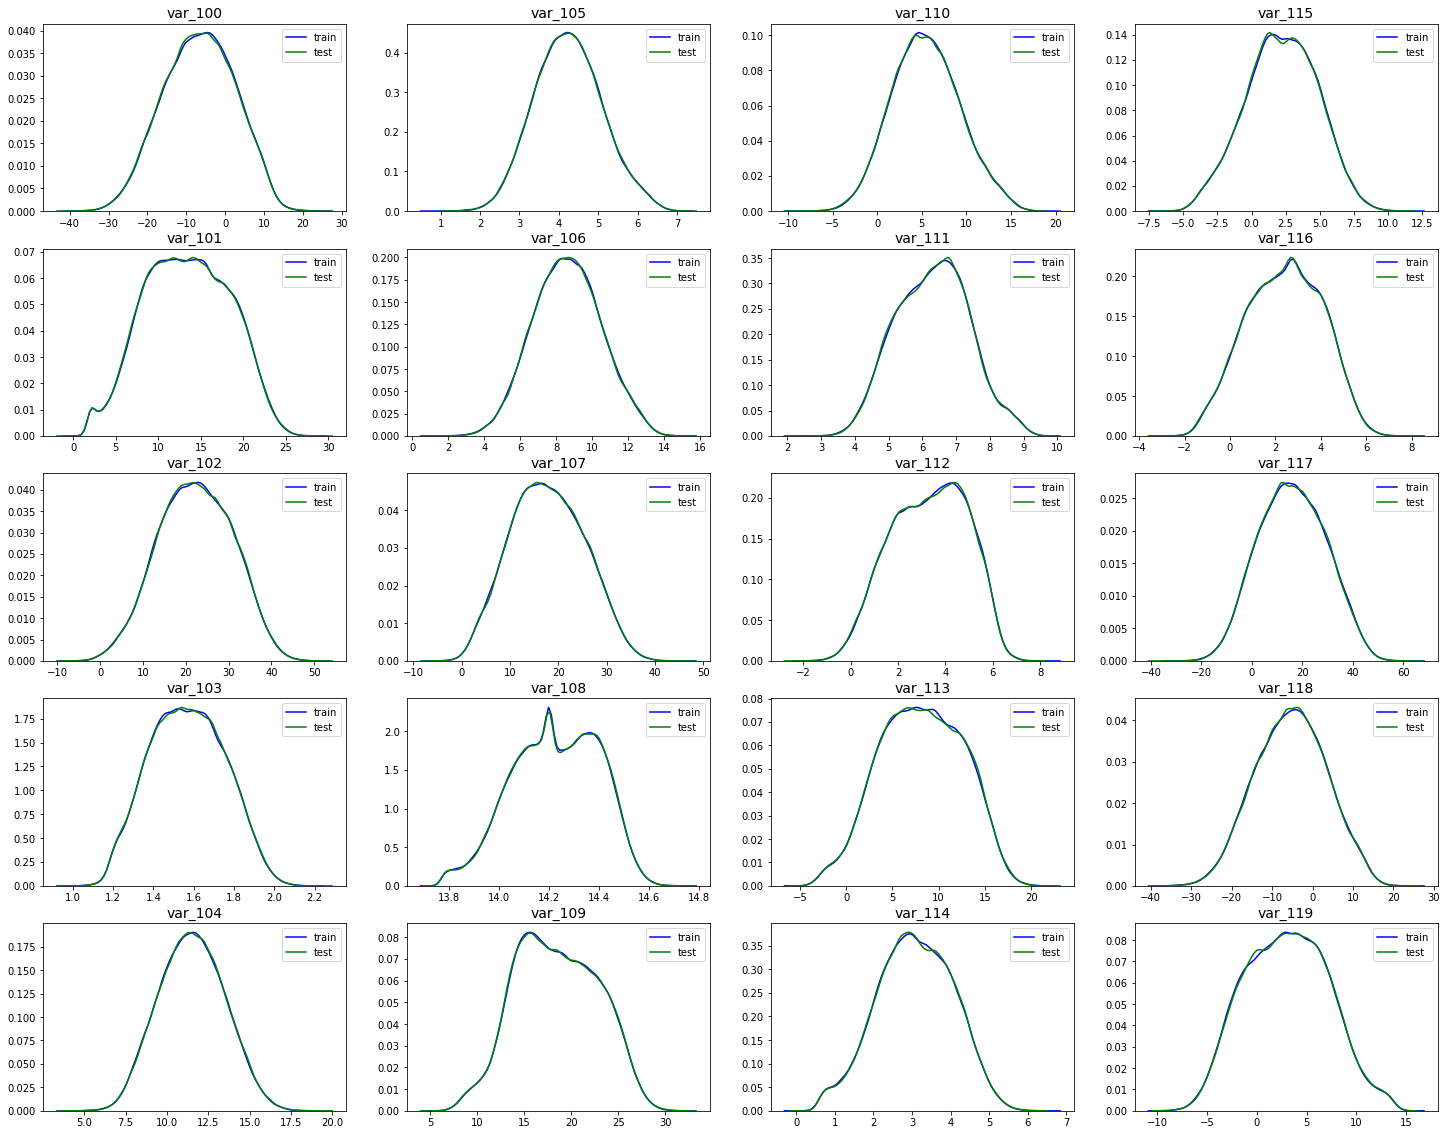

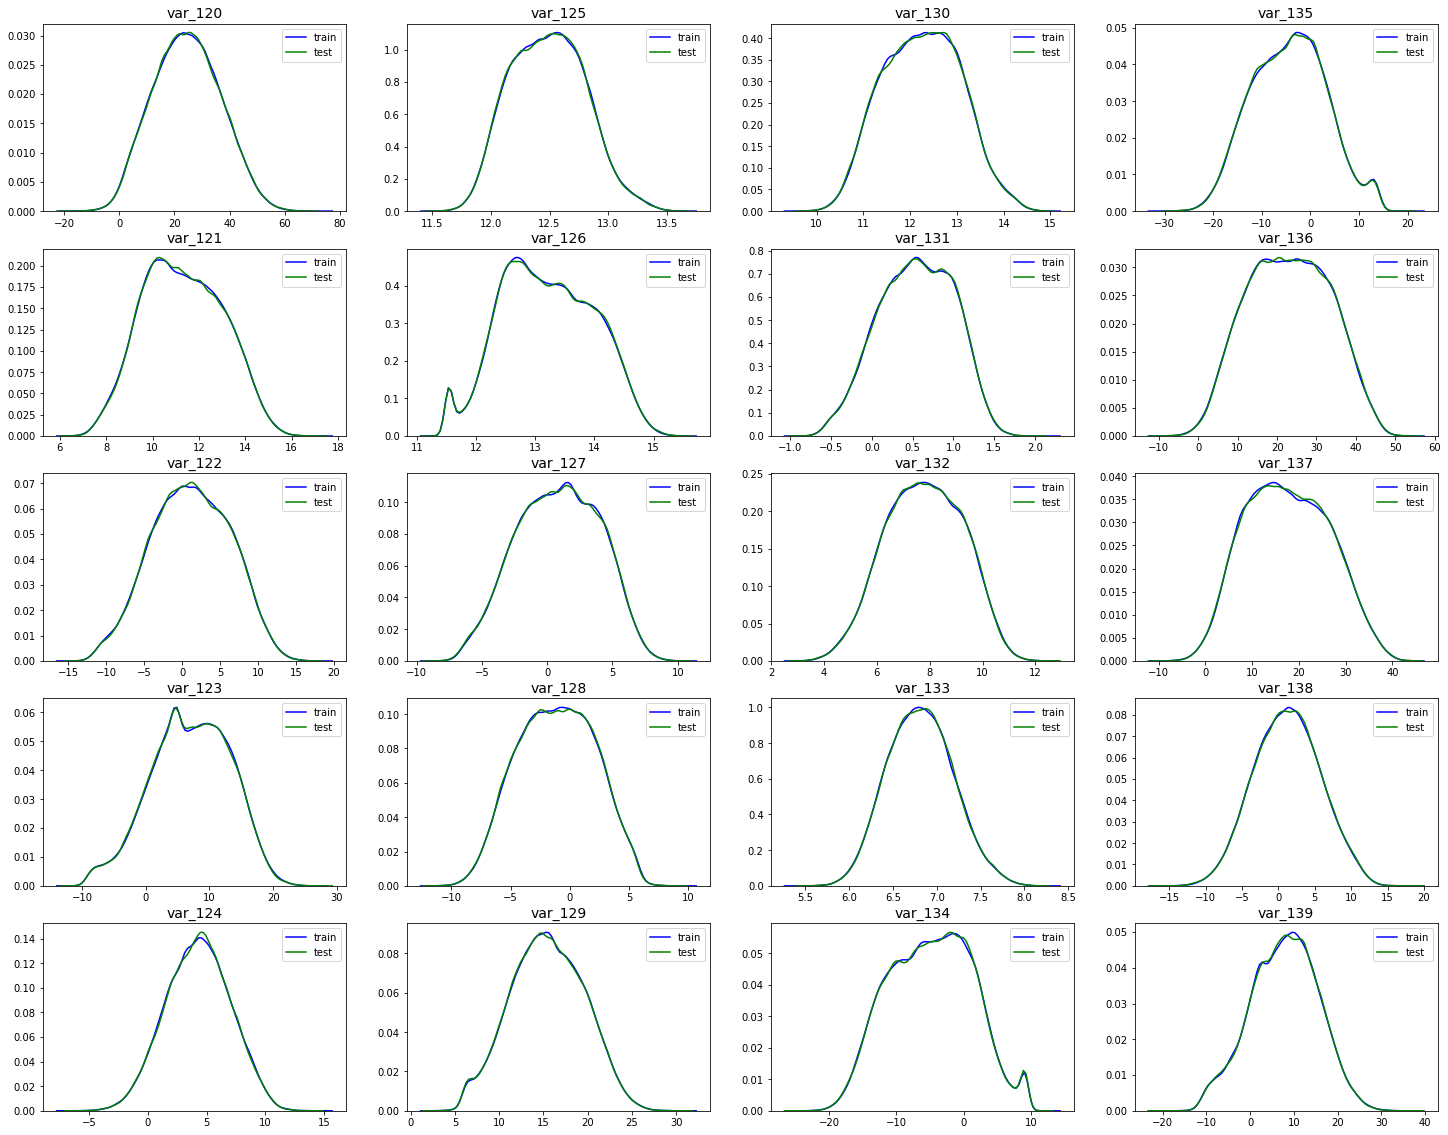

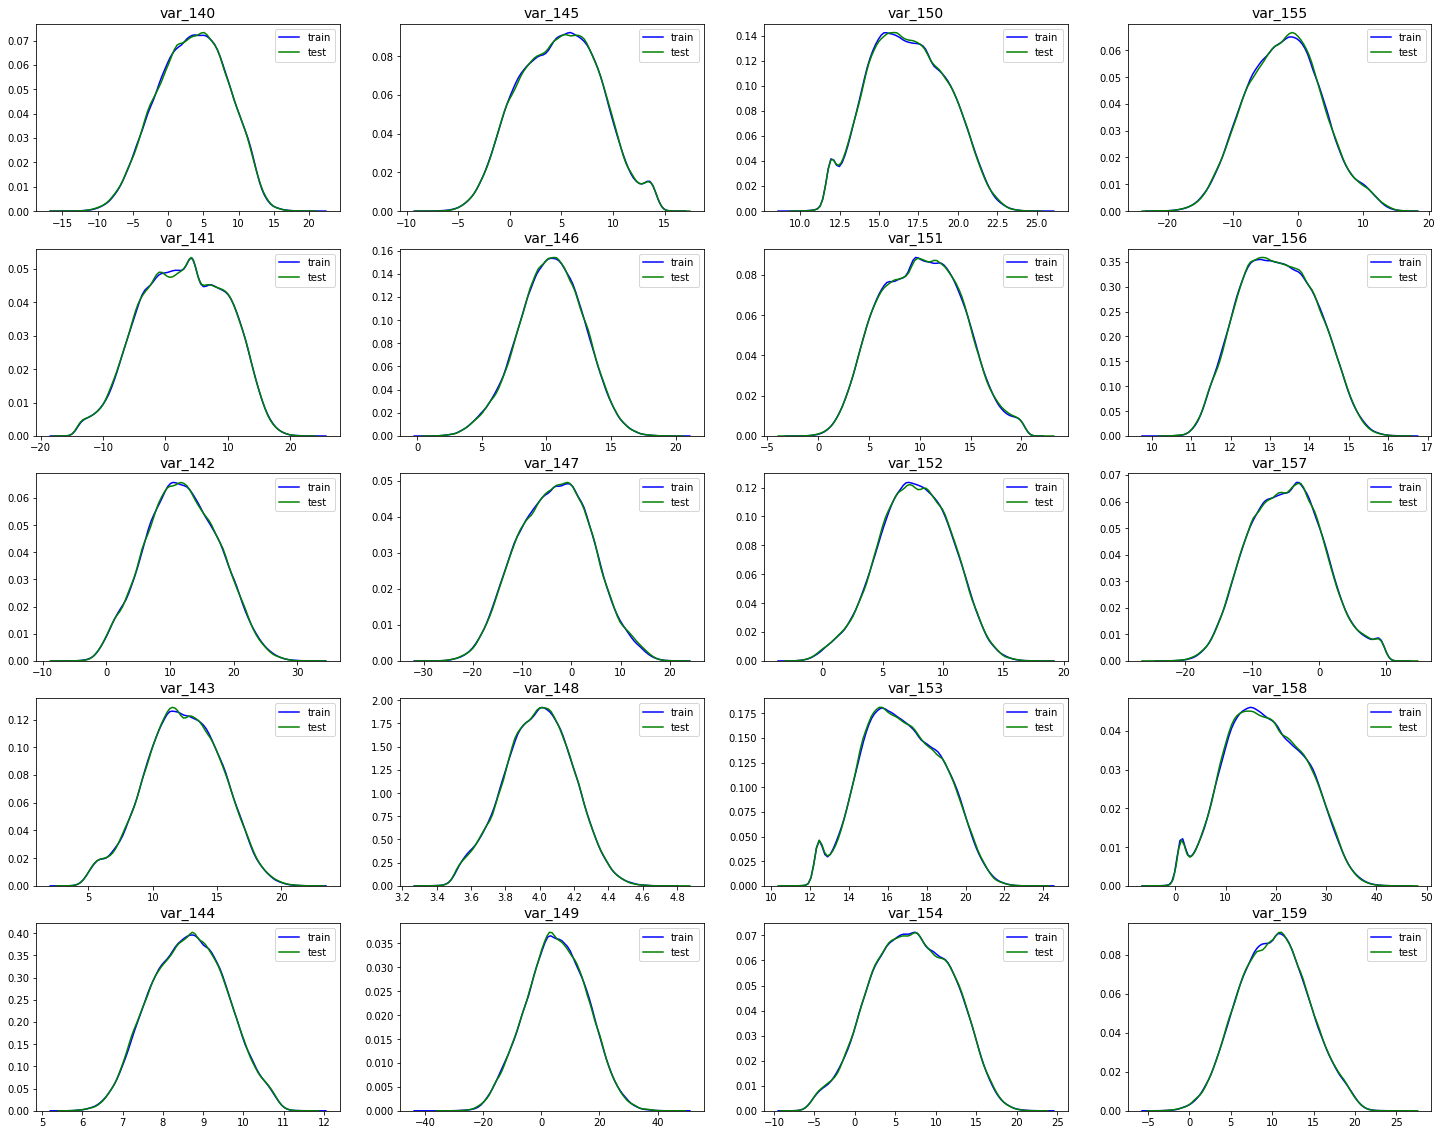

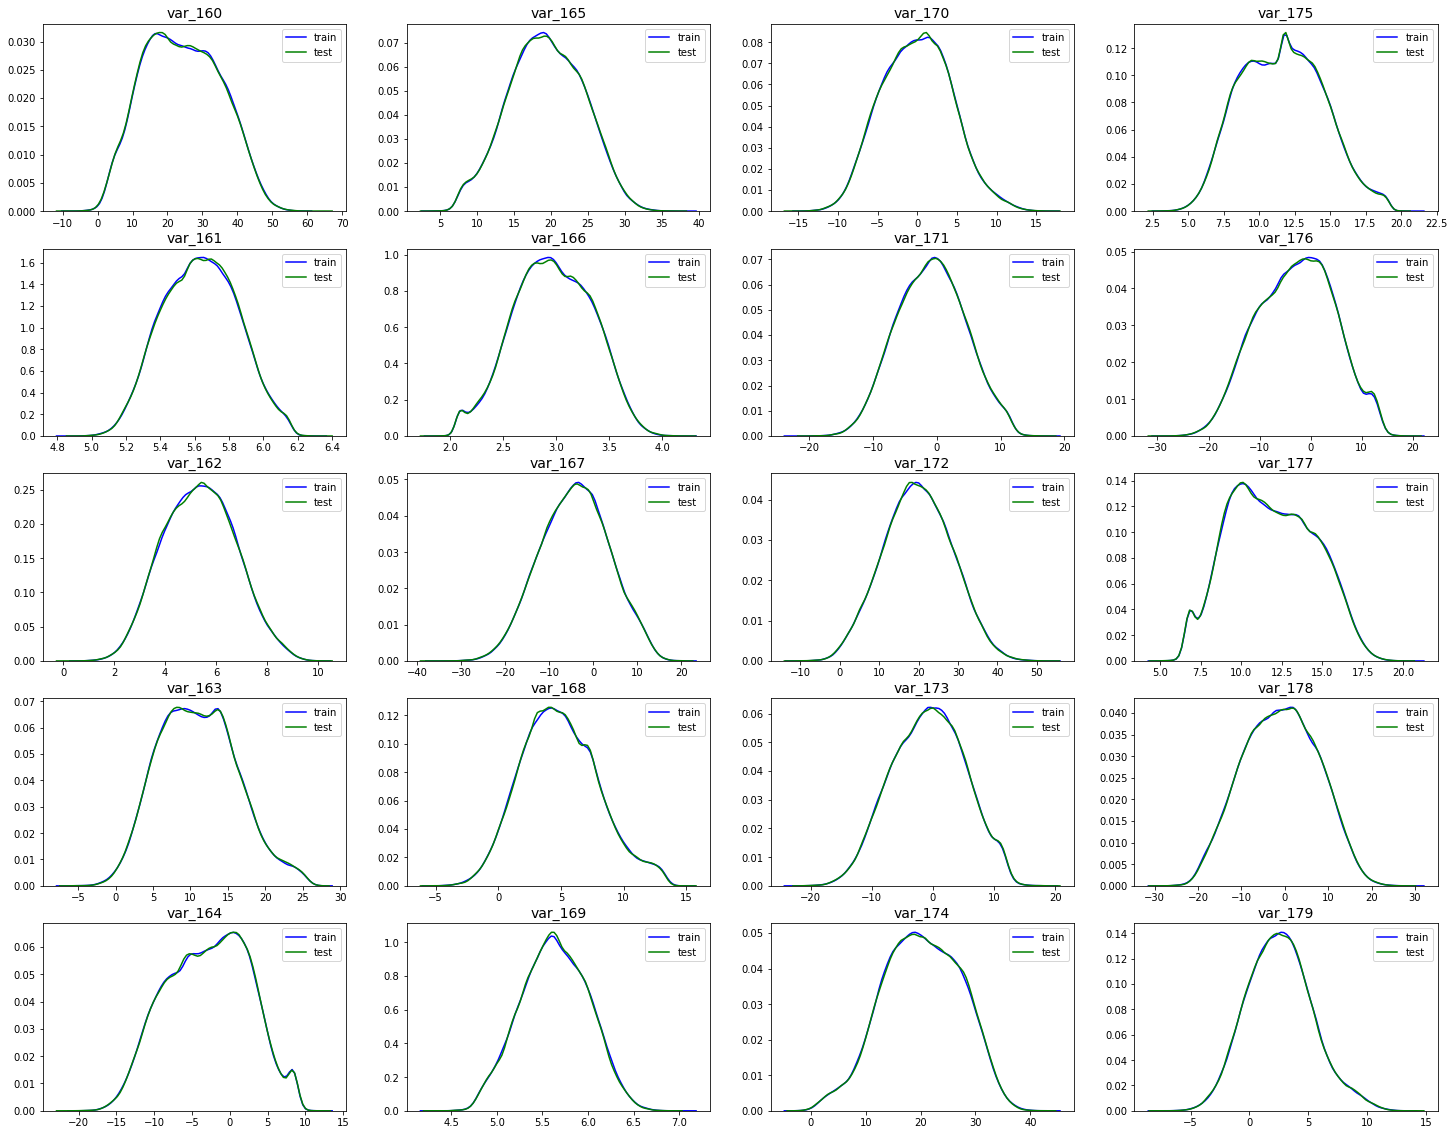

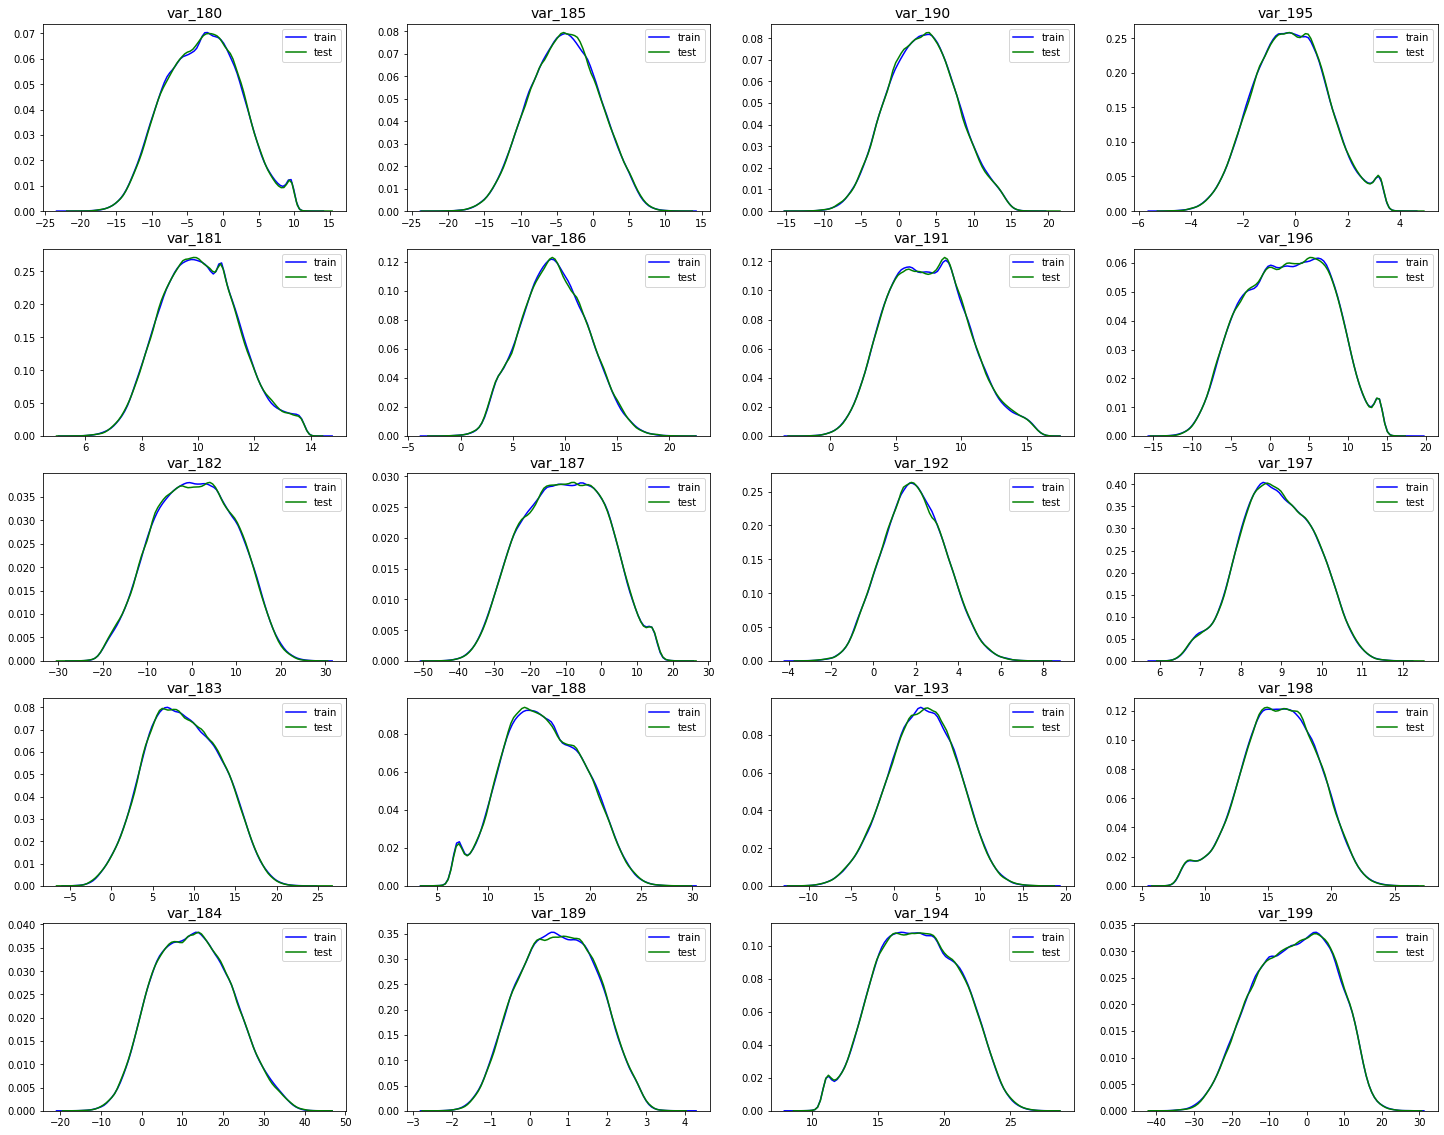

In [64]:
g = group(continuous_feature, 20)

for i in g:
    fig, axes = plt.subplots(5, 4, figsize=(25, 20))

    for num, feature in enumerate(list(i)):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num%5, num//5], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num%5, num//5], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num%5, num//5], color="blue", label="train")
        axes[num%5, num//5].set_title(feature, fontsize=14)

Выводы: 
* по некоторым признакам (их достаточно много) можно задать определенный верхний порог, например, если значение признака больше 10, то класс 1 иначе 0 и т.д. Также можно задать нижний порог. 
* распределения на тестовой и обучающей выборке ничем не отличаются, т.е те значения порогов, которые мы зададим на трейне, будут работать и для теста.

### 4. Распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки

In [22]:
lst = []
for num, feature in enumerate(continuous_feature):
    d = {}
    d["var_name"] = feature
    d["class_0_std"] = train[train['target']==0][feature].std()
    d["class_1_std"] = train[train['target']==1][feature].std()
    d["class_0_mean"] = train[train['target']==0][feature].mean()
    d["class_1_mean"] = train[train['target']==1][feature].mean()
    d["train_mean"] = train[feature].mean()
    d["test_mean"] = test[feature].mean()
    d["train_std"] = train[feature].std()
    d["test_std"] = test[feature].std()
    lst.append(d)

In [23]:
lst

[{'var_name': 'var_0',
  'class_0_std': 3.0085635212977366,
  'class_1_std': 3.27029310122627,
  'class_0_mean': 10.62668097464175,
  'class_1_mean': 11.15641803662056,
  'train_mean': 10.679914251999998,
  'test_mean': 10.658737106499999,
  'train_std': 3.0400508706688223,
  'test_std': 3.0367155808199016},
 {'var_name': 'var_1',
  'class_0_std': 4.024812721033275,
  'class_1_std': 4.220637674232161,
  'class_0_mean': -1.6957696701537506,
  'class_1_mean': -1.0176128321225992,
  'train_mean': -1.6276216895,
  'test_mean': -1.62424378,
  'train_std': 4.050044189954996,
  'test_std': 4.0405091451343695},
 {'var_name': 'var_2',
  'class_0_std': 2.6129614947393676,
  'class_1_std': 2.8410753666142945,
  'class_0_mean': 10.66587563840313,
  'class_1_mean': 11.156633053040103,
  'train_mean': 10.715191851000002,
  'test_mean': 10.707451979500002,
  'train_std': 2.6408941917999016,
  'test_std': 2.633888454459117},
 {'var_name': 'var_3',
  'class_0_std': 2.040081619820193,
  'class_1_std': 2

In [24]:
table = pd.DataFrame(lst)

In [25]:
table

var_name  class_0_std  class_1_std  class_0_mean  class_1_mean  \
0      var_0     3.008564     3.270293     10.626681     11.156418   
1      var_1     4.024813     4.220638     -1.695770     -1.017613   
2      var_2     2.612961     2.841075     10.665876     11.156633   
3      var_3     2.040082     2.070898      6.788979      6.864113   
4      var_4     1.620103     1.649266     11.072412     11.131337   
..       ...          ...          ...           ...           ...   
195  var_195     1.422275     1.485975     -0.155601     -0.021130   
196  var_196     5.441118     5.556892      2.260297      2.688583   
197  var_197     0.917467     0.952554      8.919032      8.810815   
198  var_198     2.978539     3.248123     15.924058     15.393283   
199  var_199    10.434525    10.435910     -3.415273     -2.532243   

     train_mean  test_mean  train_std   test_std  
0     10.679914  10.658737   3.040051   3.036716  
1     -1.627622  -1.624244   4.050044   4.040509  
2     10.715192  10.707452   2.640894   2.633888  
3      6.796529   6.788214   2.043319   2.052724  
4     11.078333  11.076399   1.623150   1.616456  
..          ...        ...        ...        ...  
195   -0.142088  -0.133657   1.429372   1.429678  
196    2.303335   2.290899   5.454369   5.446346  
197    8.908158   8.912428   0.921625   0.920904  
198   15.870720  15.869184   3.010945   3.008717  
199   -3.326537  -3.246342  10.438015  10.398589  

[200 rows x 9 columns]

Выводы: 
* у некоторых признаков среднее по классу 1 выше, чем по классу 0.
* среднее и стандартное отклонение на трейне и тесте почти одинаково, очень похоже.

### 5. Построить распределение коэффициентов корреляции между признаками.

In [26]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

In [27]:
corr_with_target = correlation["target"].sort_values(ascending = True)
corr_with_target

var_81    -0.080917
var_139   -0.074080
var_12    -0.069489
var_146   -0.063644
var_76    -0.061917
             ...   
var_26     0.062422
var_53     0.063399
var_110    0.064275
var_6      0.066731
target     1.000000
Name: target, Length: 201, dtype: float64

Text(0, 0.5, 'Density')

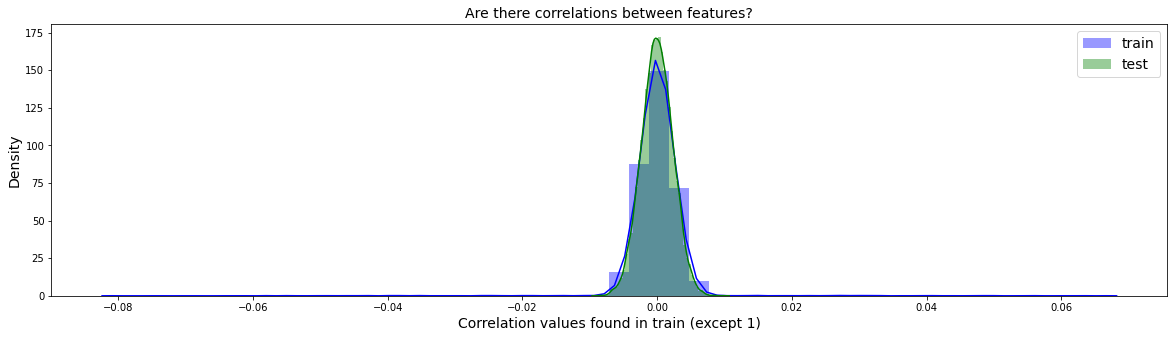

In [28]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Выводы: ни один из признаков не коррелирует с таргетом ни с другим признаком (все значения меньше 0.2).

### 6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [31]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), train['target'])

Wall time: 6min 7s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

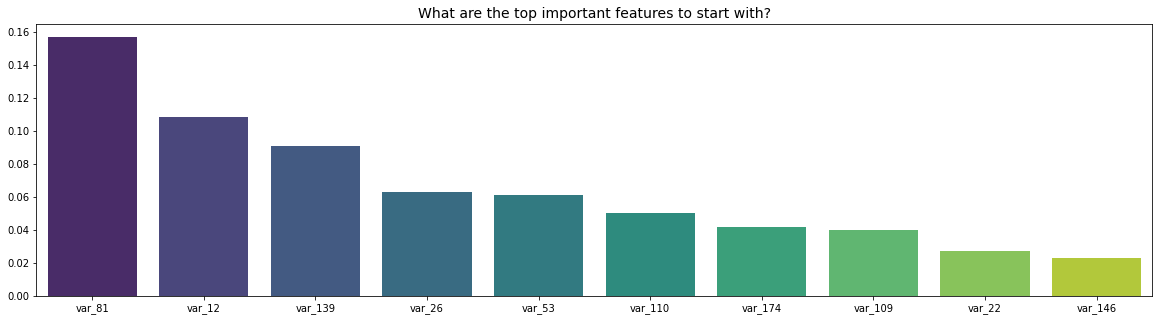

In [32]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### 7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках

Adversarial Validation

In [34]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()

In [35]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [41]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 9min 28s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

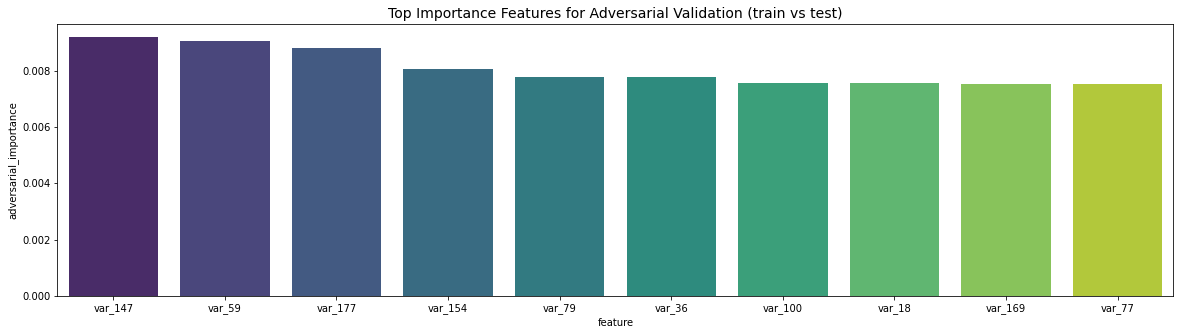

In [42]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

Выводы: roc_auc примерно равен 0.5, седовательно, верна гипотеза о том, что обучая модель на некоторых данных она будет работать на таких же данных.